In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pde import ImplicitSolver
plt.rcParams['figure.dpi'] = 300


In [3]:
conda activate pypde



Note: you may need to restart the kernel to use updated packages.


In [28]:
from mpl_toolkits.mplot3d import Axes3D   #plotting function

def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

# m.shape must be (10,10)
m = np.fromfunction(lambda x, y: np.sin(np.sqrt(x**2 + y**2)), (10, 10))

#(fig, ax, surf) = surface_plot(sol[1].data, cmap=plt.cm.coolwarm)




Make initial Conditions

In [29]:
N = 50
   
def gkern(l, sig):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    X = kernel / np.sum(kernel)
    for i in range(len(X)):
        for j in range(len(X)):
            if X[i,j] < 1e-5:
                X[i, j] = 0
    return X
#print(gkern(N, 1))



(<Figure size 1800x1200 with 1 Axes>,
 <Axes3D: >,
 <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x29444ef55b0>)

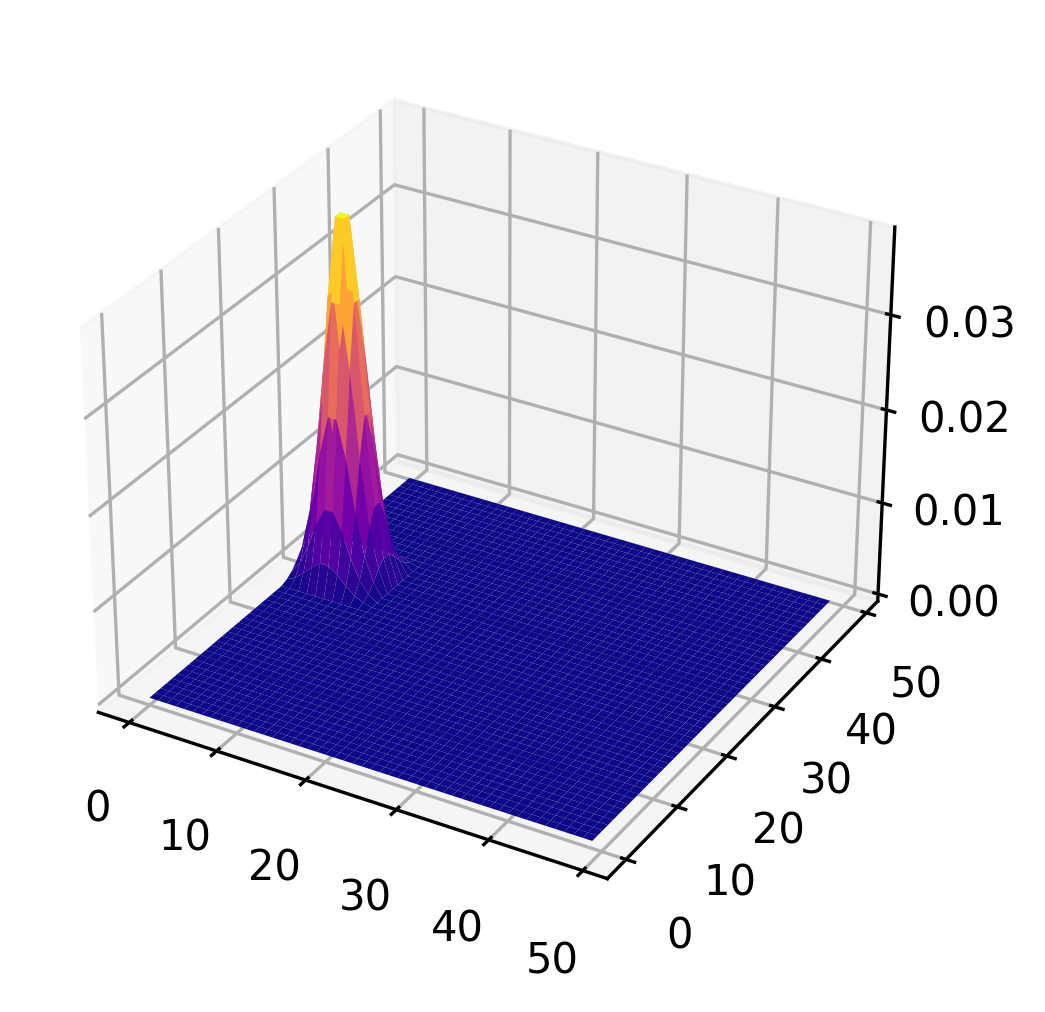

In [30]:
X = gkern(10, 2)
P_1 = np.zeros((N, N))
P_1[25:35 ,0:10] = X
P_1 = P_1/np.sum(P_1)
surface_plot(P_1, cmap=plt.cm.plasma)    #this is the parasitoid initial condition


(<Figure size 1800x1200 with 1 Axes>,
 <Axes3D: >,
 <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x29446254f40>)

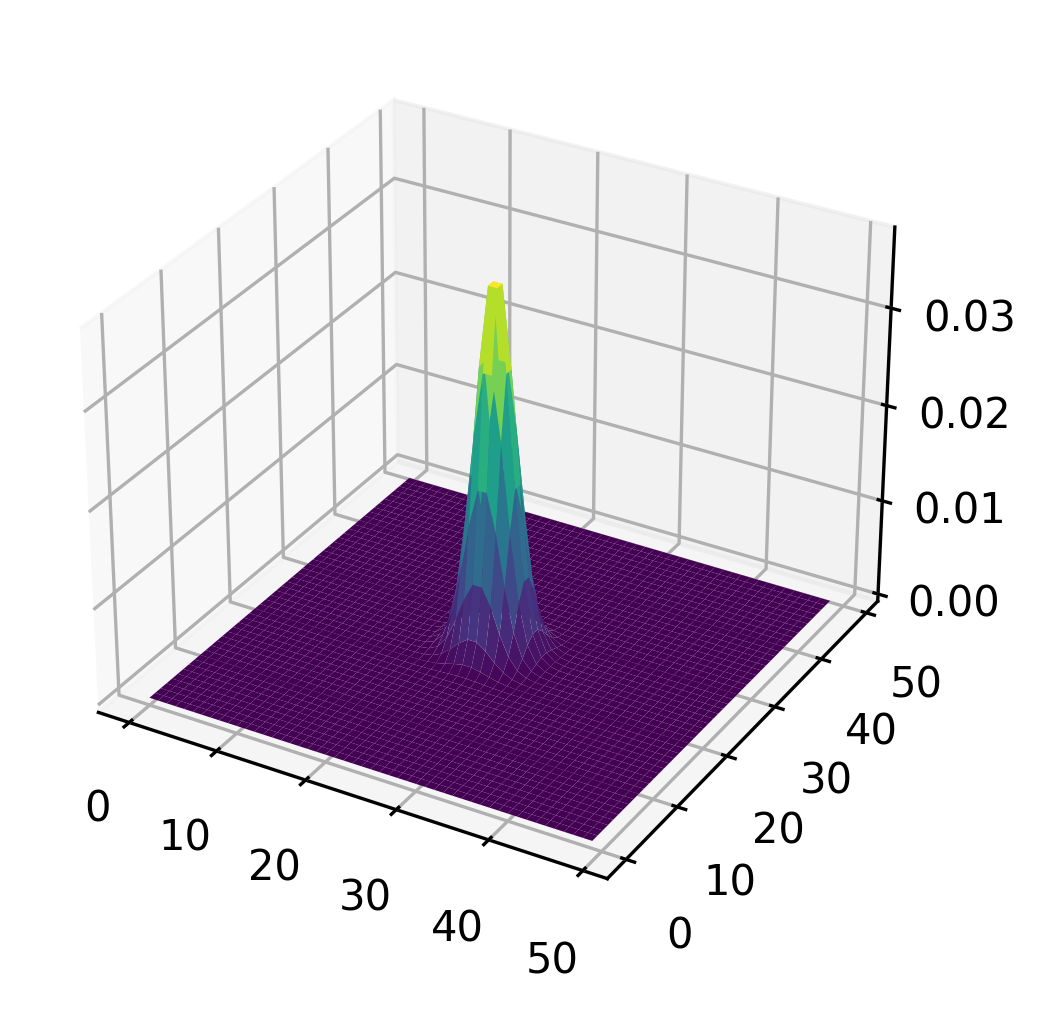

In [31]:
#large central custer 
A_1 = gkern(N, 2) #this is the aphid initail condition
surface_plot(A_1, cmap=plt.cm.viridis)

In [32]:
def solve_pde(params):
    N = 50

    # ram parameters 
    D_p = params[0]
    D_c = params[1]
    al = params[2]
    r = params[3]
    del_h = params[4]
    del_p = params[5]
    e_s = params[6]
    e_d = params[7]
    Sds = params[8]
    Ssd = params[9]
    b_1 = params[10]
    b_2 = params[11]
    b_3 = params[12]
    chi = params[13]
    mu = params[14]
    
    # non-d parameters
    D_cc = (D_c)/D_p
    al_p = (al)/r
    ka_s = al_p*e_s*(r - del_h)
    ka_d = al_p*e_d*(r - del_h)

    B_1 = b_1
    B_2 = b_2
    B_3 = b_3*10/(r - del_h)
    zeta = 1e-6
    del_p = del_p/(r-del_h)
    
    # boundary conditions
    bc_x_left = {"derivative": 0.0}
    bc_x_right = {"derivative": 0.0}
    bc_y_left = {"derivative": 0.0}
    bc_y_right = {"derivative": 0.0}

    bc = [[bc_x_left, bc_x_right], [bc_y_left, bc_y_right]]

    # pde
    eq = PDE(
        {   "P": f" -   {mu} * dot(gradient(Hs + Hd), gradient(P)) / (1 + {mu}*(Hs + Hd))**2  +   laplace(P) / (1 + {mu} * (Hs + Hd)) -\
          (dot(gradient(P), gradient(C)) + P * laplace(C) ) + {ka_s} * Hs * P * (Hs + Hd * {Sds}) /(Hs + Hd + {zeta})  +  {ka_d} * Hd * P - {del_p} * P",
            "C": f"{D_cc} * laplace(C) + ({B_1} * Hs + {B_2} * Hd) - {B_3} * C ",
            "Hs": f"(Hs * (1 - Hs - Hd) - {ka_s} * Hs * P * (Hs + Hd * {Sds}) /(Hs + Hd + {zeta})) ",
            "Hd": f"(Hd * (1 - Hs - Hd) - {ka_d} * Hd * P)",
        }, bc = bc
    )

    # initialize state
    grid = UnitGrid([50, 50])


    data_c = np.zeros((50, 50))
    P = ScalarField(grid, P_1, label="Field $P$")
    Hs =  ScalarField(grid, A_1, label="Field $Hs$")
    Hd =  ScalarField(grid, A_1, label="Field $Hd$")
    C =  ScalarField(grid, data_c, label="Field $C$")

    state = FieldCollection([P, C, Hs, Hd])
    # simulate the pde
    storage = MemoryStorage()
    trackers = ["progress", storage.tracker(interval = 2)]

    solver = ImplicitSolver(eq)
    control = Controller(solver, t_range=240, tracker = trackers)   #240 time = 240*(10)=2400 hrs = 100 days
    sol = control.run(state, dt = 1e-2)  #dt = time step
    
    #-------------------------
    ## sum over the field
    #-------------------------
    P_sum = []   #appends the total densities 
    C_sum = []
    H_s_sum = [] 
    H_d_sum = []

#     P_val = []   #appends the full matrix 
#     C_val = []
#     H_s_val = []

    for i in range(0, 120):  #t_range = 240, we stored the solution at times intervals of 5. 240/5 = 48  
        P_sum.append(storage[i][0].integral)   #append total mass in each glass house
        C_sum.append(storage[i][1].integral)
        H_s_sum.append(storage[i][2].integral)
        H_d_sum.append(storage[i][3].integral)

#         P_val.append(storage[i][0].data)   #append matrix values 
#         C_val.append(storage[i][1].data)
#         H_s_val.append(storage[i][2].data)
    return (P_sum, C_sum, H_s_sum, H_d_sum)


This runs the simulation

In [68]:
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, ImplicitSolver, Controller, MemoryStorage
import numpy as np

# ram parameters 
D_p = 0.0005 #m^2s^{-1}
D_c = 0.0005 
al = 1
r = 2.55
del_h = 0.15
del_p = 0.15
e_s = 0.3
e_d = 0.2
Sds = 0.65
Ssd = 1
b_1 = 1
b_2 = 1
b_3 = 0.2
chi = 0.01
mu = 1

# varying mu
μ = [.1, .5, 1, 2, 3, 4]

P = np.ndarray((360, len(μ)))
C = np.ndarray((360, len(μ)))
H_s = np.ndarray((360, len(μ)))
H_d = np.ndarray((360, len(μ)))


for i in range(len(μ)):
    mu = μ[i]

    parms = [D_p, D_c, al, r, del_h, del_p, e_s, e_d, Sds, Ssd, b_1, b_2, b_3, chi, mu]
    
    P[:,i], C[:,i], H_s[:, i], H_d[:,i]  = solve_pde(params=parms)
    

  0%|          | 0/720.0 [00:00<?, ?it/s]

  0%|          | 0/720.0 [00:00<?, ?it/s]

  0%|          | 0/720.0 [00:00<?, ?it/s]

  0%|          | 0/720.0 [00:00<?, ?it/s]

  0%|          | 0/720.0 [00:00<?, ?it/s]

  0%|          | 0/720.0 [00:00<?, ?it/s]

Take all the solution values from storage and add to lists for plotting 

### Plot total densities 

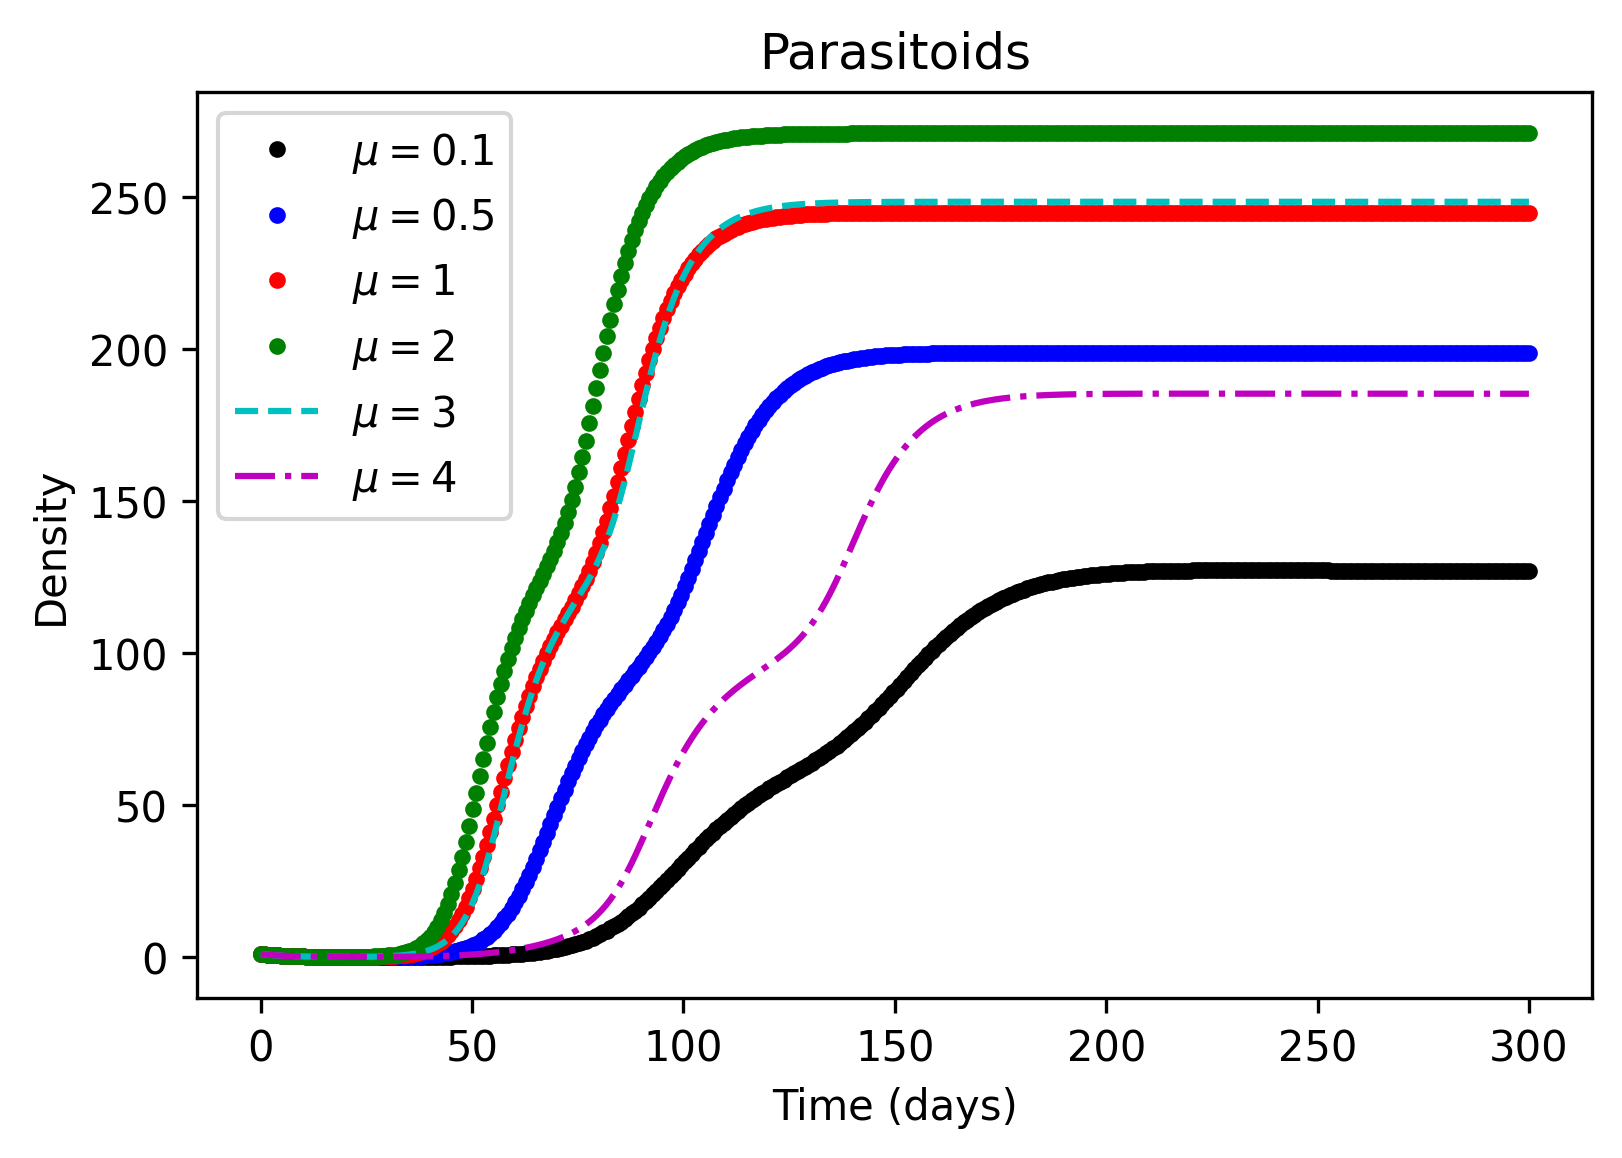

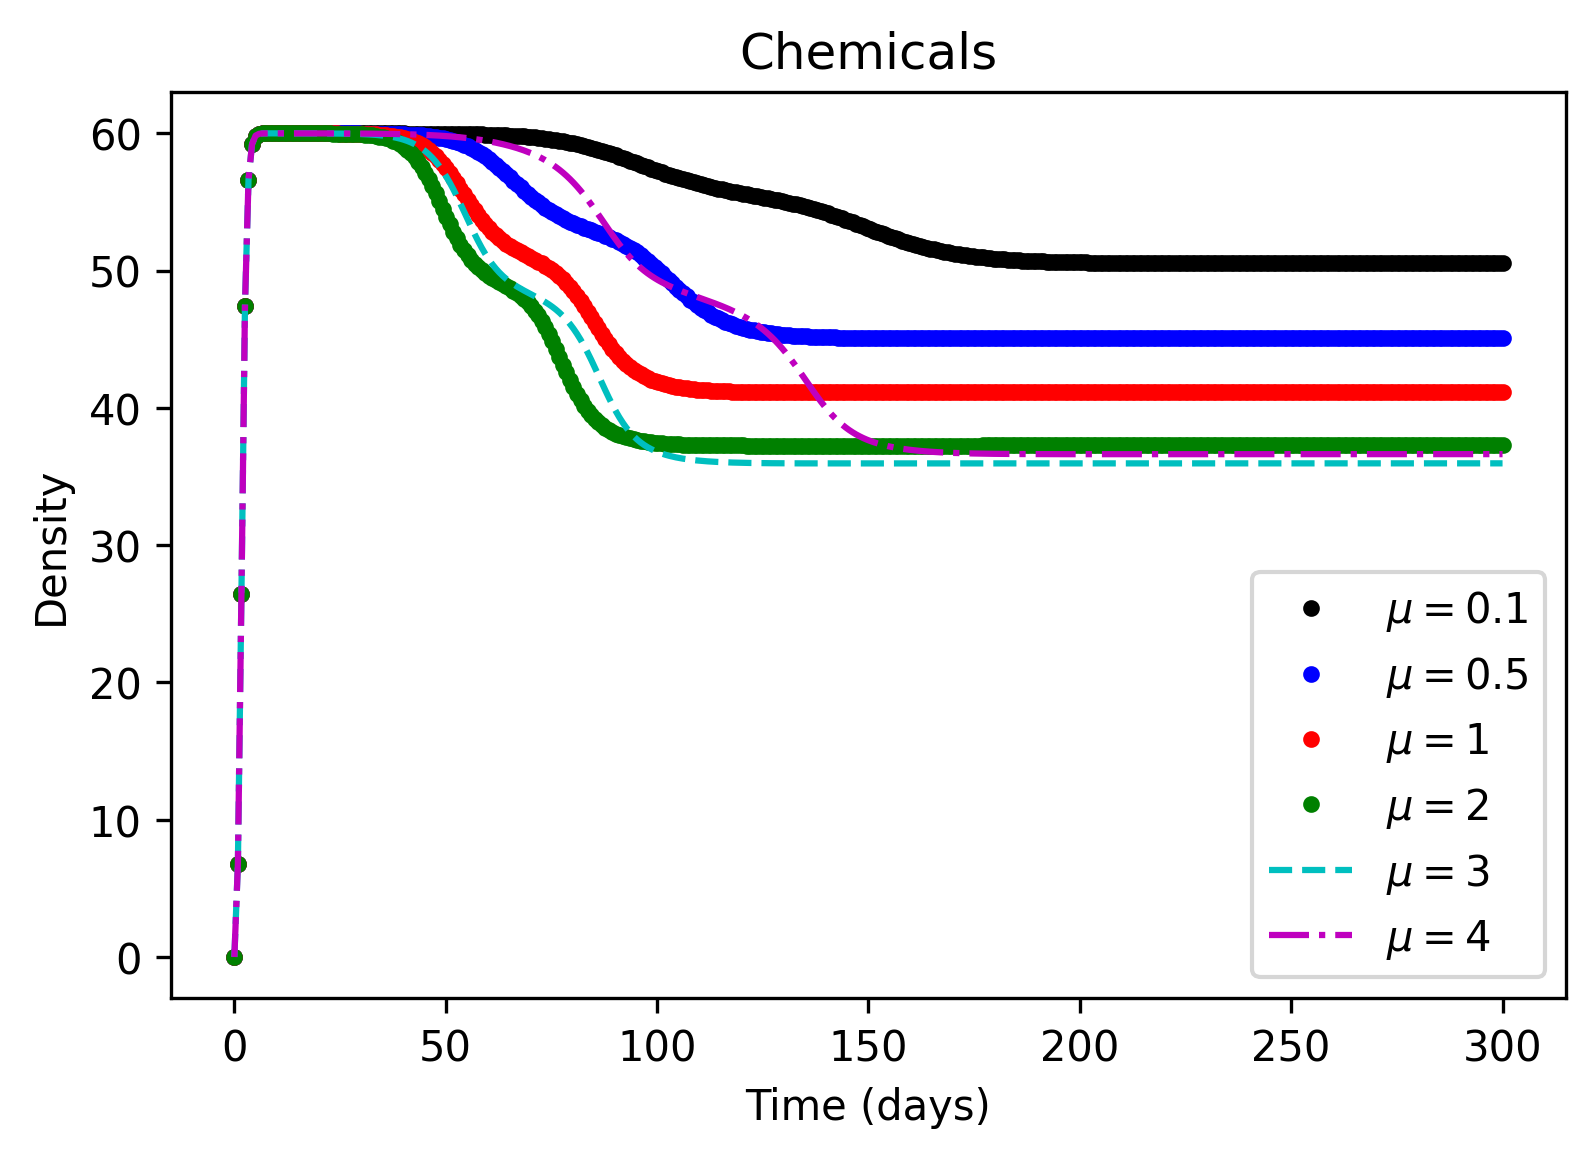

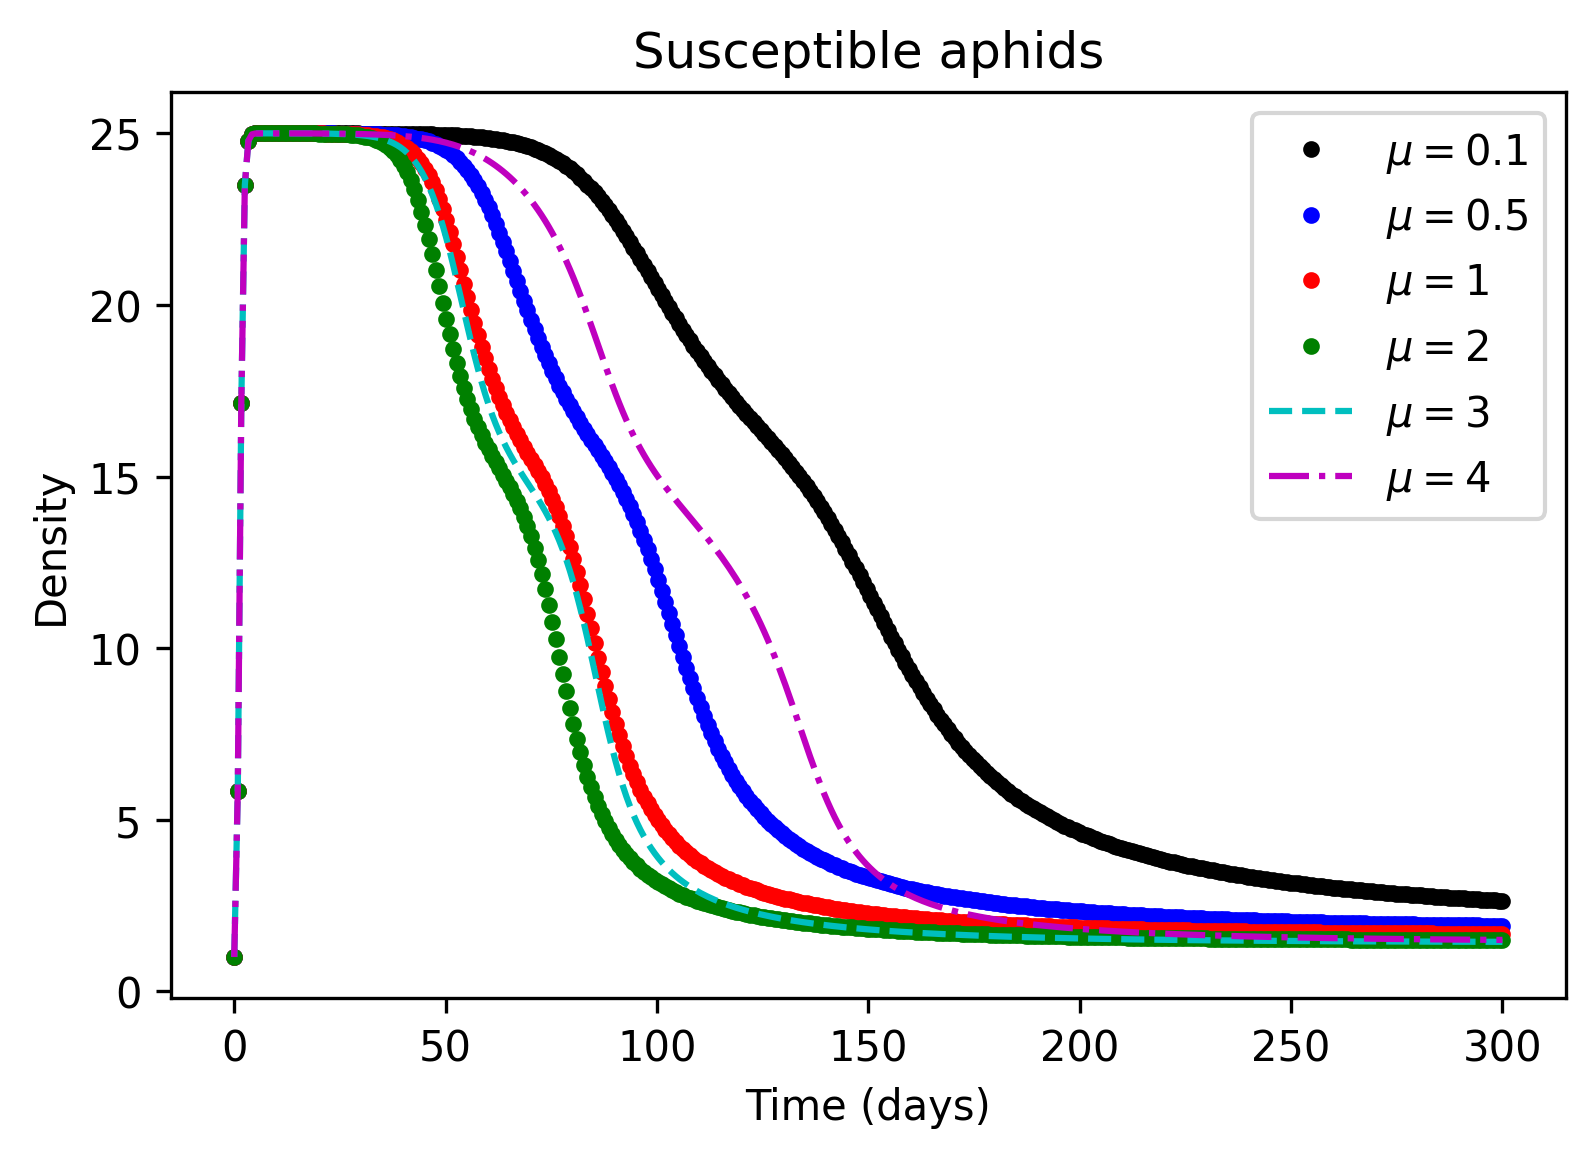

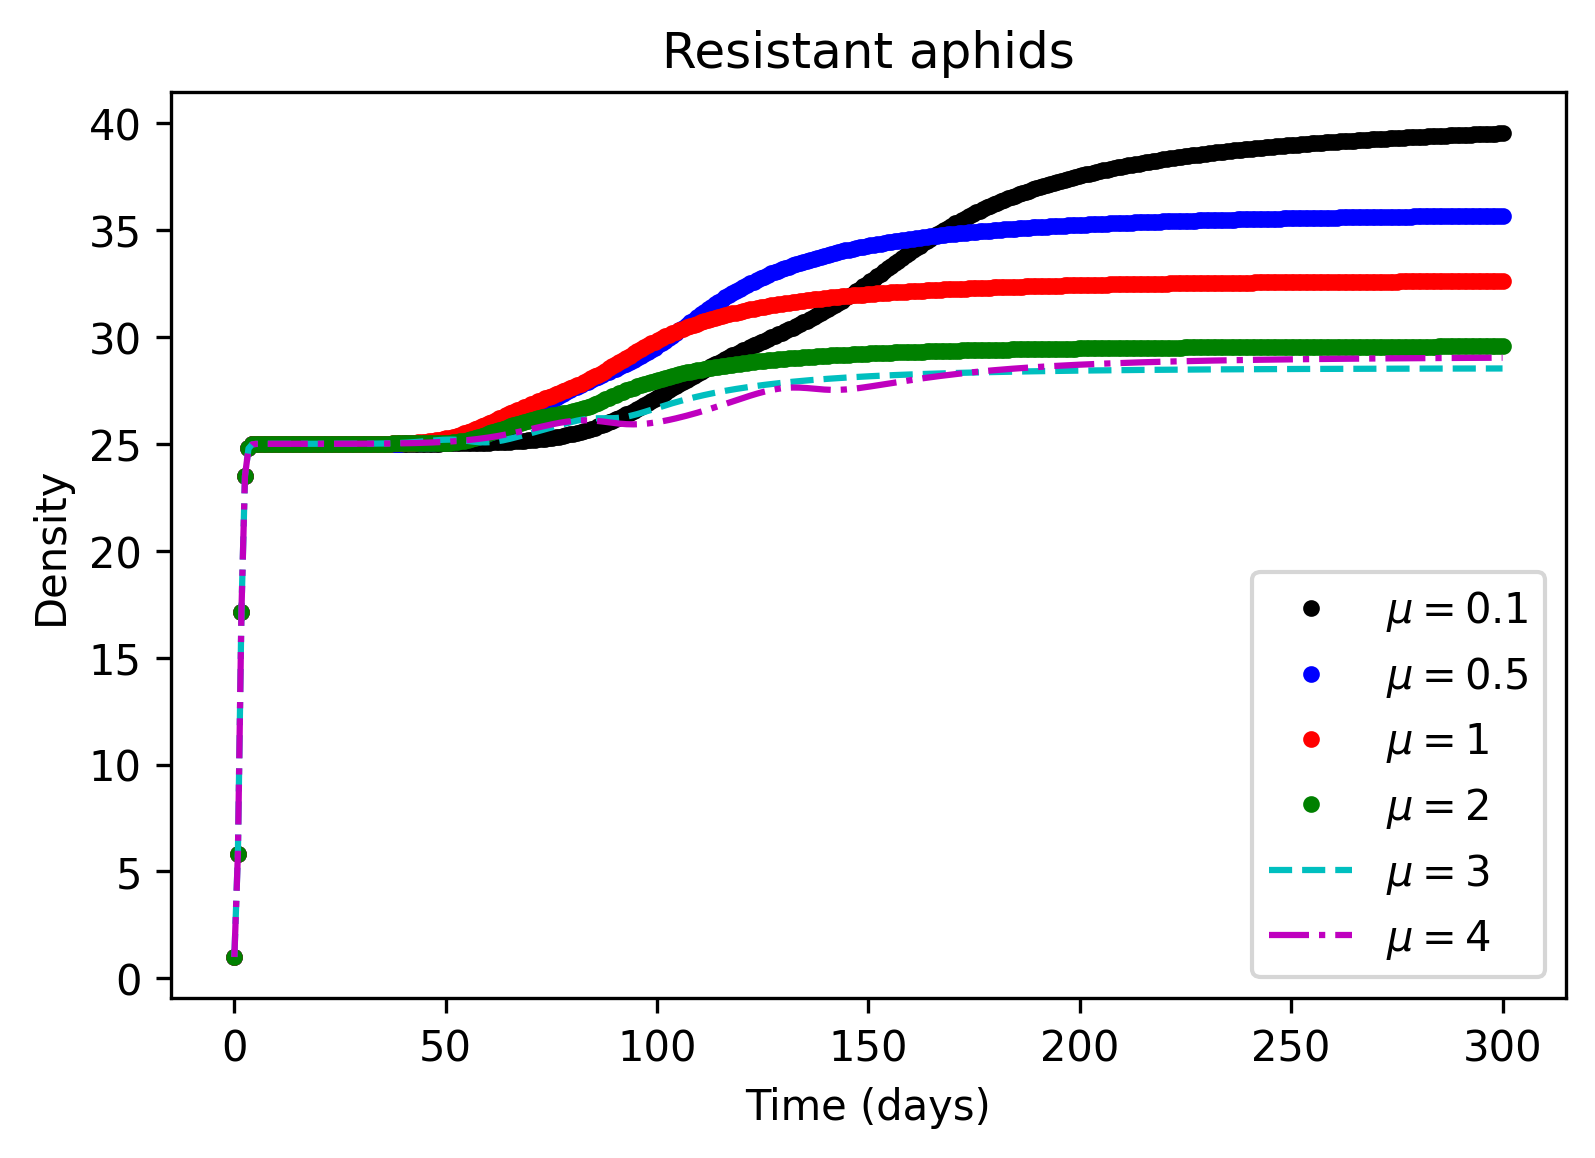

In [75]:
colors = ['k.', 'b.', 'r.', 'g.', 'c--', 'm-.', 'y-.', 'k-.']
time = np.linspace(0, 300, 360)
for i in range(len(μ)):
    plt.plot(time, P[:,i], colors[i],  label="$\mu = $" + str(μ[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Parasitoids")
plt.legend()
plt.show()

for i in range(len(μ)):
    plt.plot(time, C[:,i], colors[i],  label="$\mu = $" + str(μ[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Chemicals")
plt.legend()
plt.show()

for i in range(len(μ)):
    plt.plot(time, H_s[:,i], colors[i],  label="$\mu = $" + str(μ[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Susceptible aphids")
plt.legend()
plt.show()

for i in range(len(μ)):
    plt.plot(time, H_d[:,i], colors[i],  label="$\mu = $" + str(μ[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Resistant aphids")
plt.legend()
plt.show()

### Effect of varying diffusion rates $D_P$

In [54]:
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, ImplicitSolver, Controller, MemoryStorage
import numpy as np

# ram parameters 
D_p = 0.0005 #m^2s^{-1}
D_c = 0.0005 
al = 1
r = 2.55
del_h = 0.15
del_p = 0.15
e_s = 0.3
e_d = 0.2
Sds = 0.65
Ssd = 1
b_1 = 1
b_2 = 1
b_3 = 0.2
chi = 0.01
mu = 1

# varying mu
dp = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

P1 = np.ndarray((120, len(μ)))
C1 = np.ndarray((120, len(μ)))
H_s1 = np.ndarray((120, len(μ)))
H_d1 = np.ndarray((120, len(μ)))


for i in range(len(dp)):
    D_p = dp[i]

    parms = [D_p, D_c, al, r, del_h, del_p, e_s, e_d, Sds, Ssd, b_1, b_2, b_3, chi, mu]
    
    P1[:,i], C1[:,i], H_s1[:, i], H_d1[:,i]  = solve_pde(params=parms)
    

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

IndexError: index 6 is out of bounds for axis 1 with size 6

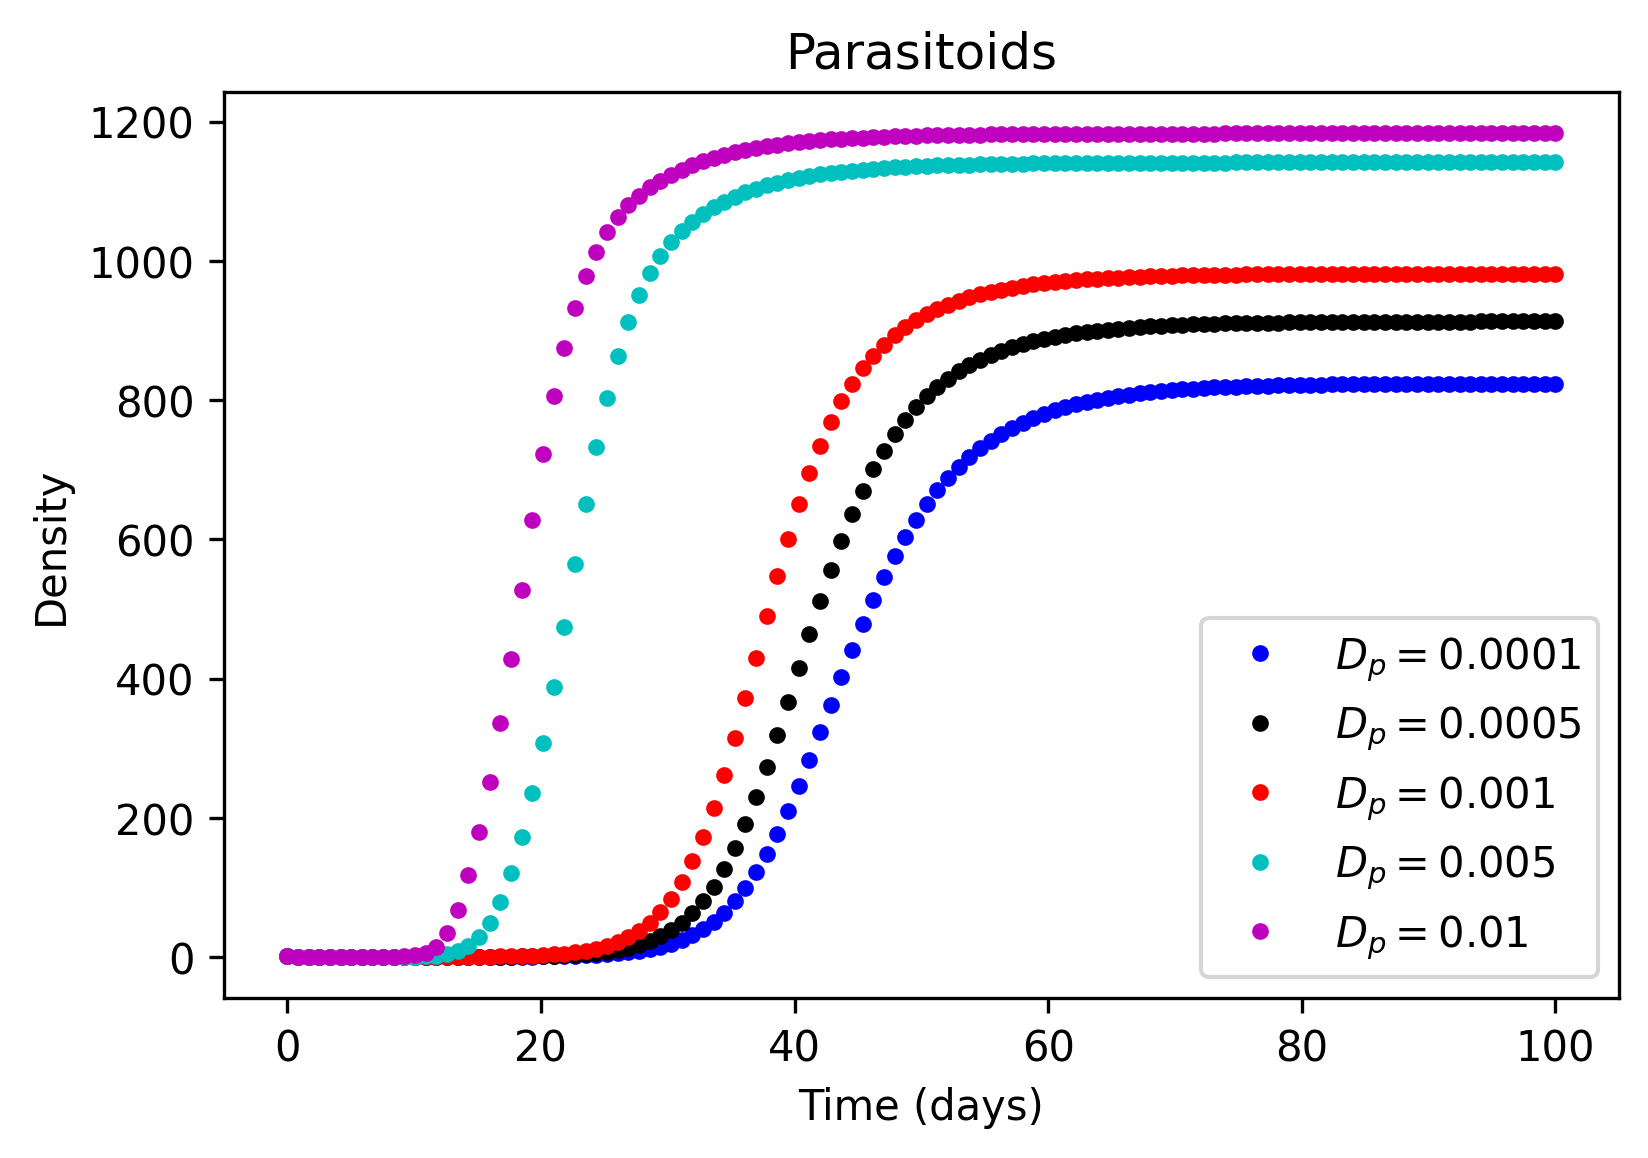

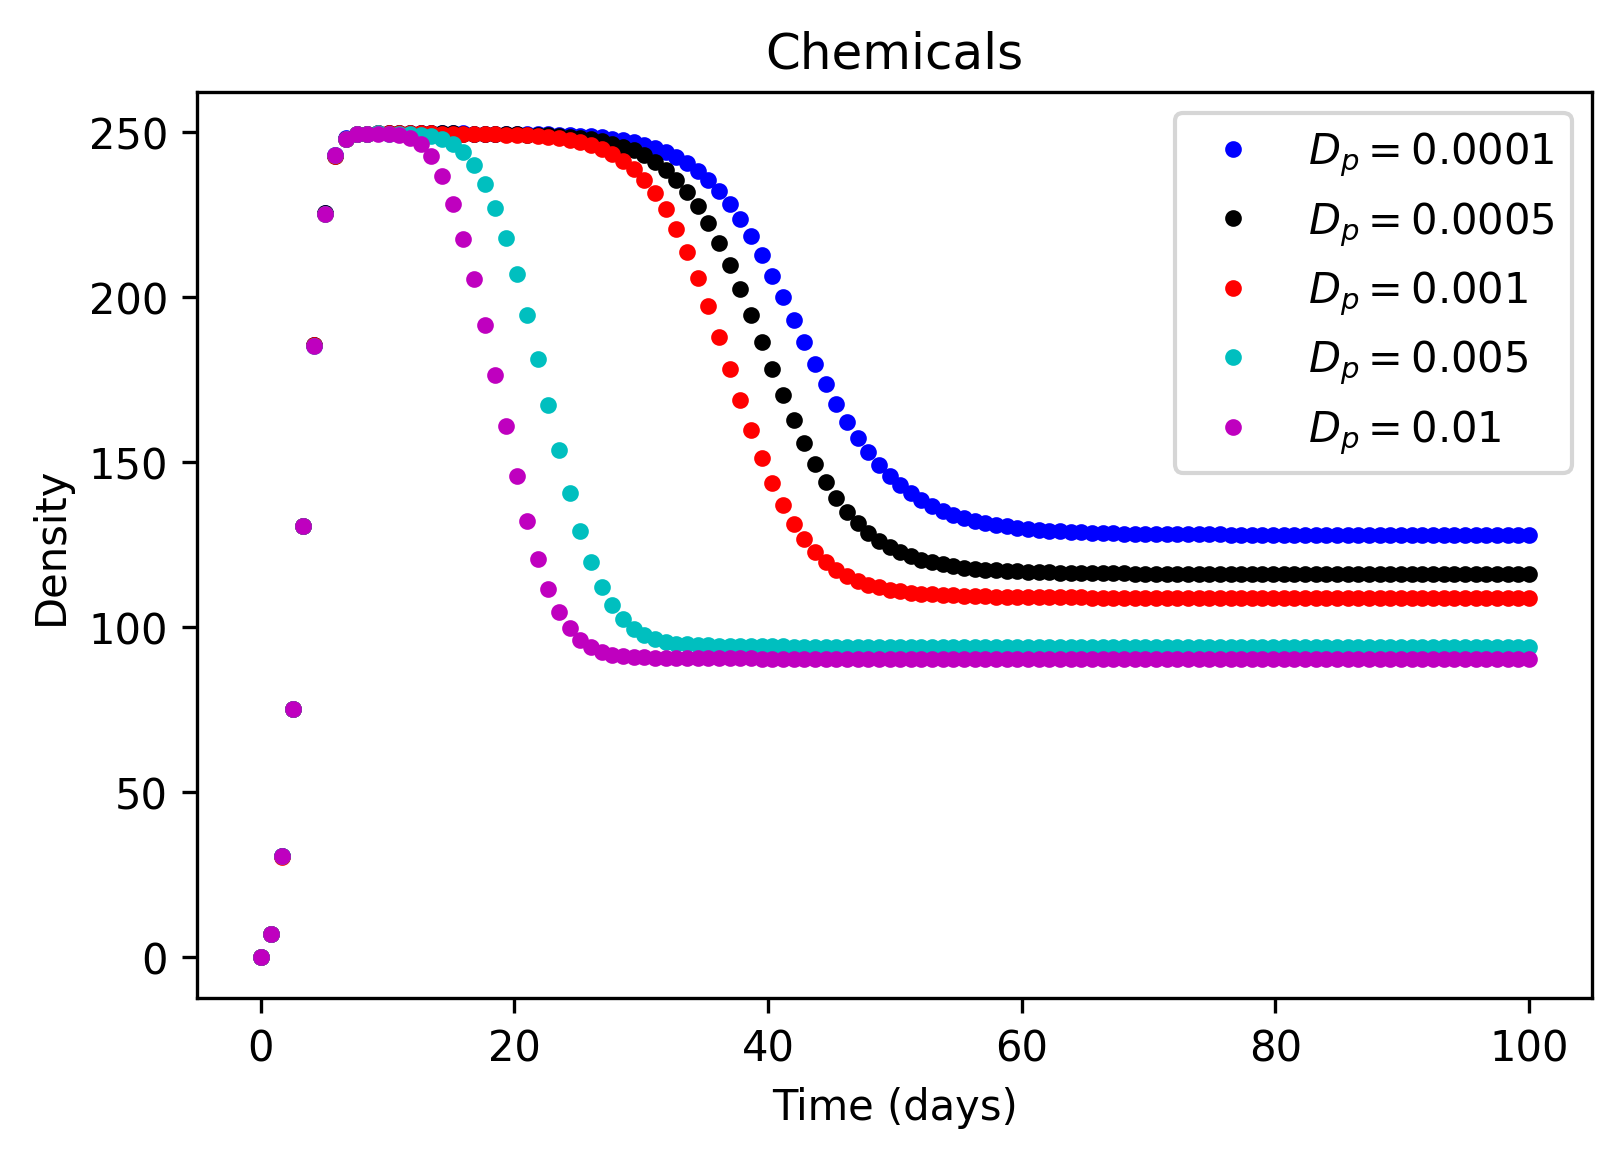

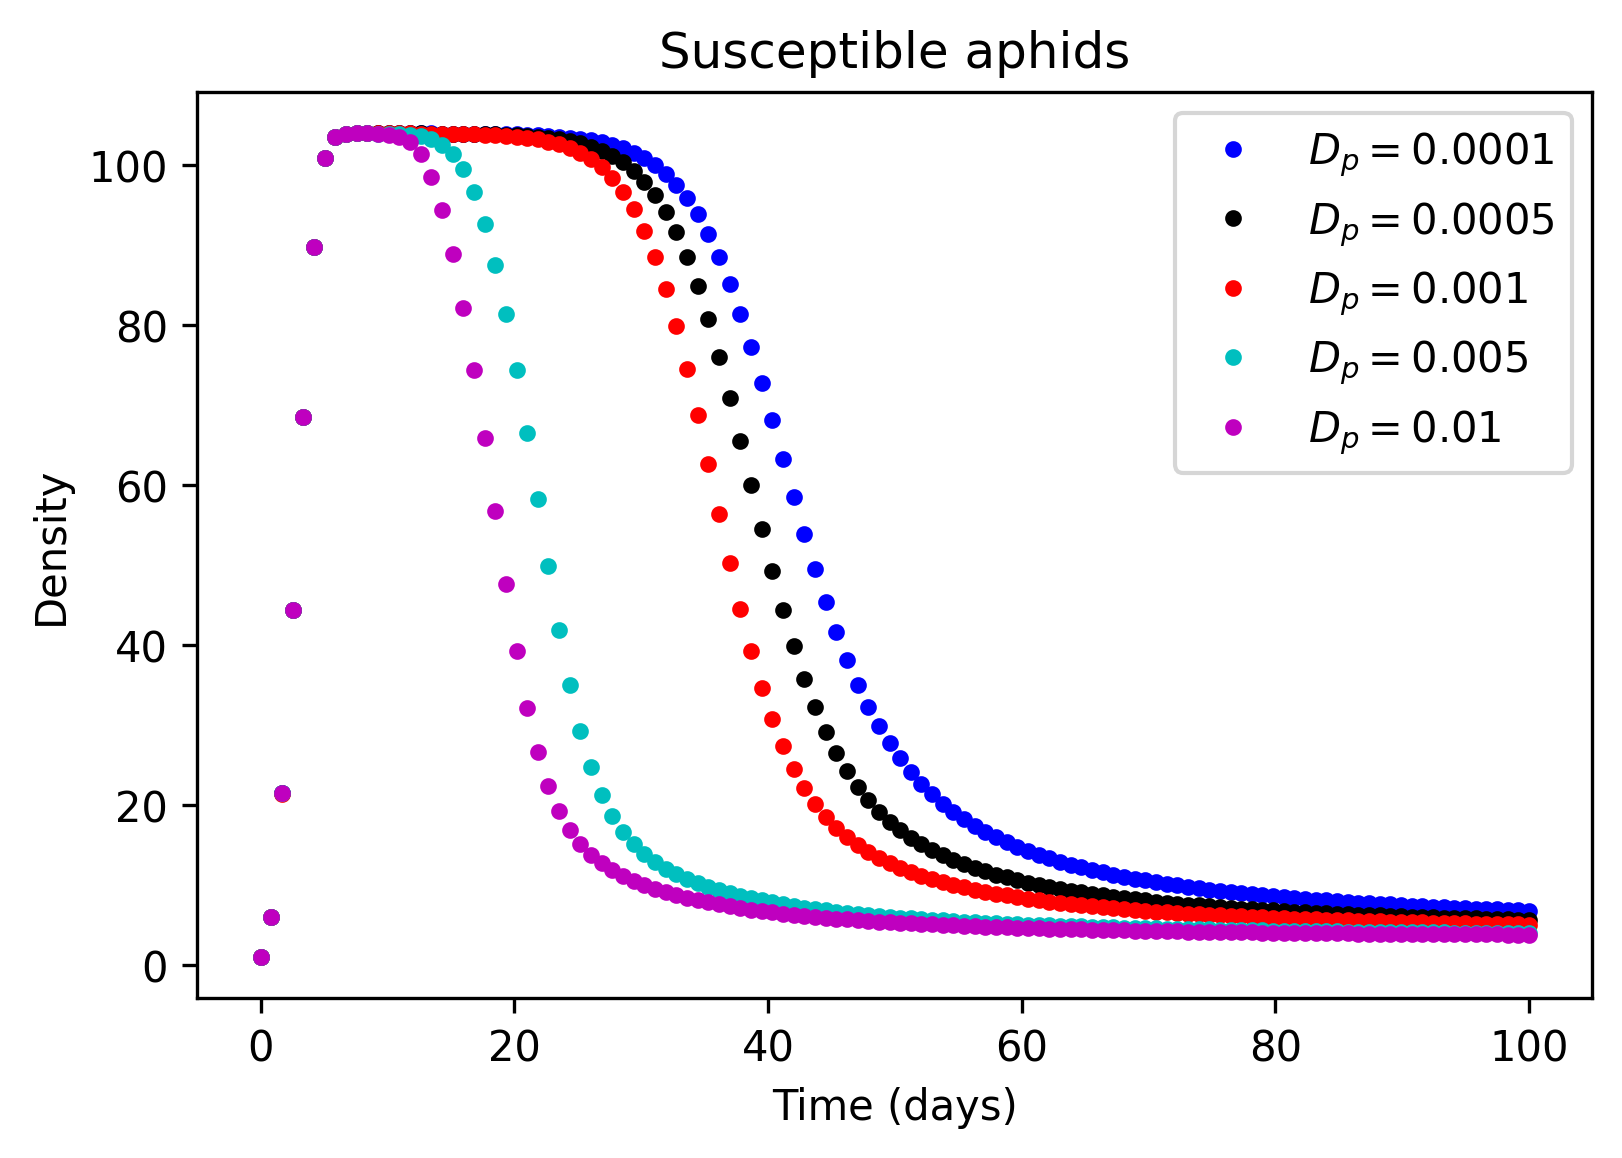

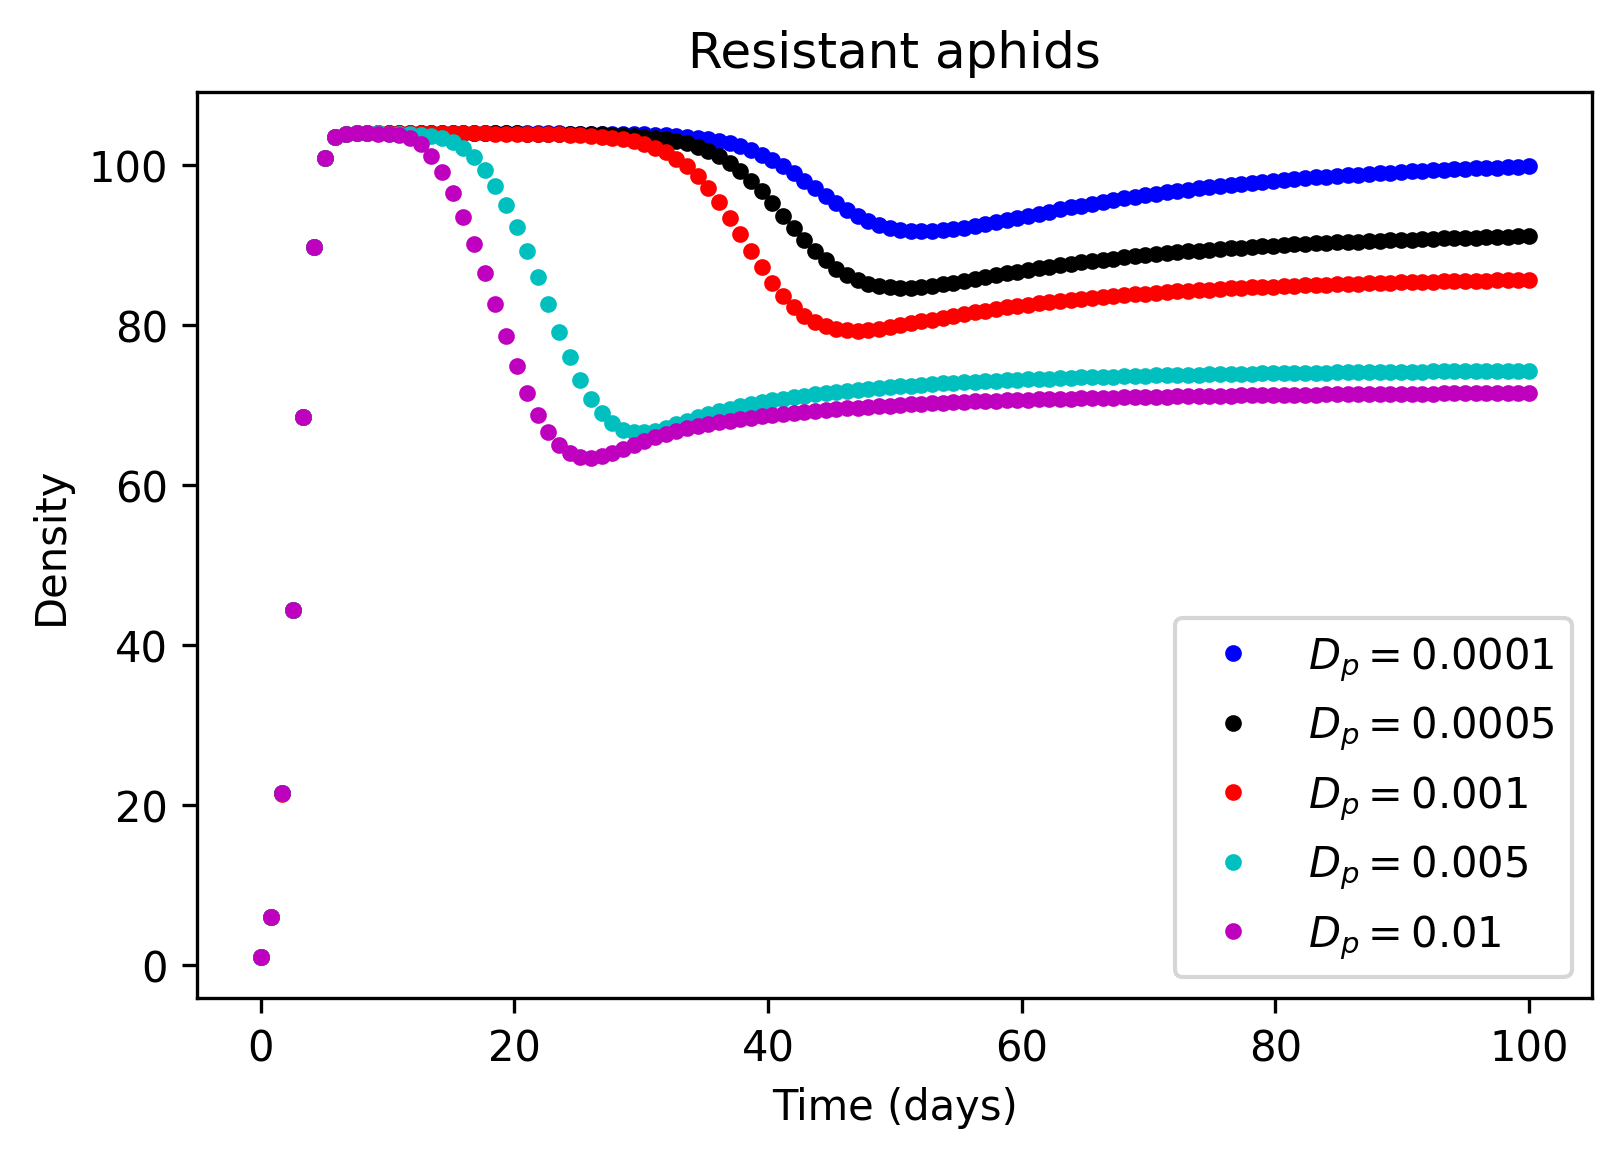

In [53]:
colors = ['b.', 'k.', 'r.', 'c.', 'm.', 'y-.', 'k-.']
time = np.linspace(0, 100, 120)
for i in range(len(dp)):
    plt.plot(time, P1[:,i], colors[i],  label="$D_p = $" + str(dp[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Parasitoids")
plt.legend()
plt.show()

for i in range(len(dp)):
    plt.plot(time, C1[:,i], colors[i],  label="$D_p = $" + str(dp[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Chemicals")
plt.legend()
plt.show()

for i in range(len(dp)):
    plt.plot(time, H_s1[:,i], colors[i],  label="$D_p = $" + str(dp[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Susceptible aphids")
plt.legend()
plt.show()

for i in range(len(dp)):
    plt.plot(time, H_d1[:,i], colors[i],  label="$D_p = $" + str(dp[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Resistant aphids")
plt.legend()
plt.show()

### Effect of varying diffusion rates $D_c$

In [59]:
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, ImplicitSolver, Controller, MemoryStorage
import numpy as np

# ram parameters 
D_p = 0.0005 #m^2s^{-1}
D_c = 0.0005 
al = 1
r = 2.55
del_h = 0.15
del_p = 0.15
e_s = 0.3
e_d = 0.2
Sds = 0.65
Ssd = 1
b_1 = 1
b_2 = 1
b_3 = 0.2
chi = 0.01
mu = 1

# varying mu
dc = [0.00001, .00005, 0.0001, 0.0005]

P2 = np.ndarray((120, len(μ)))
C2 = np.ndarray((120, len(μ)))
H_s2 = np.ndarray((120, len(μ)))
H_d2 = np.ndarray((120, len(μ)))


for i in range(len(dc)):
    D_c = dc[i]

    parms = [D_p, D_c, al, r, del_h, del_p, e_s, e_d, Sds, Ssd, b_1, b_2, b_3, chi, mu]
    
    P2[:,i], C2[:,i], H_s2[:, i], H_d2[:,i]  = solve_pde(params=parms)
    

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

#### Plotting

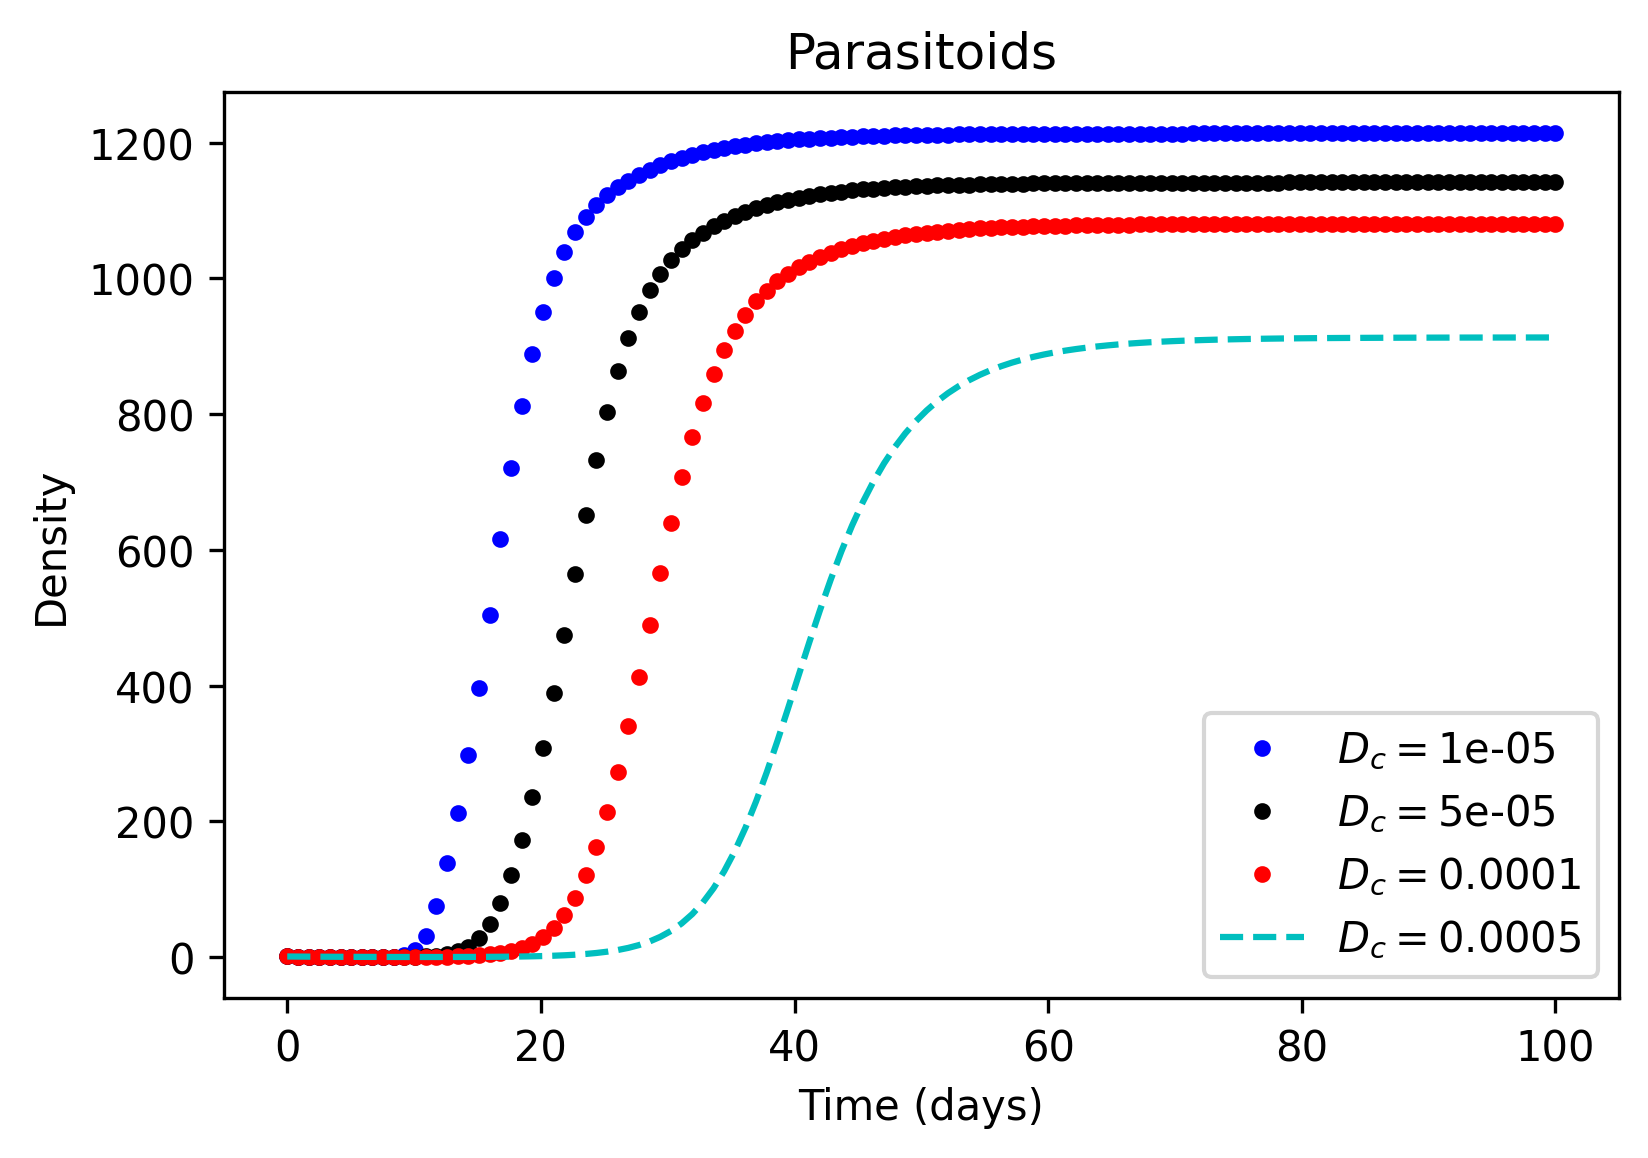

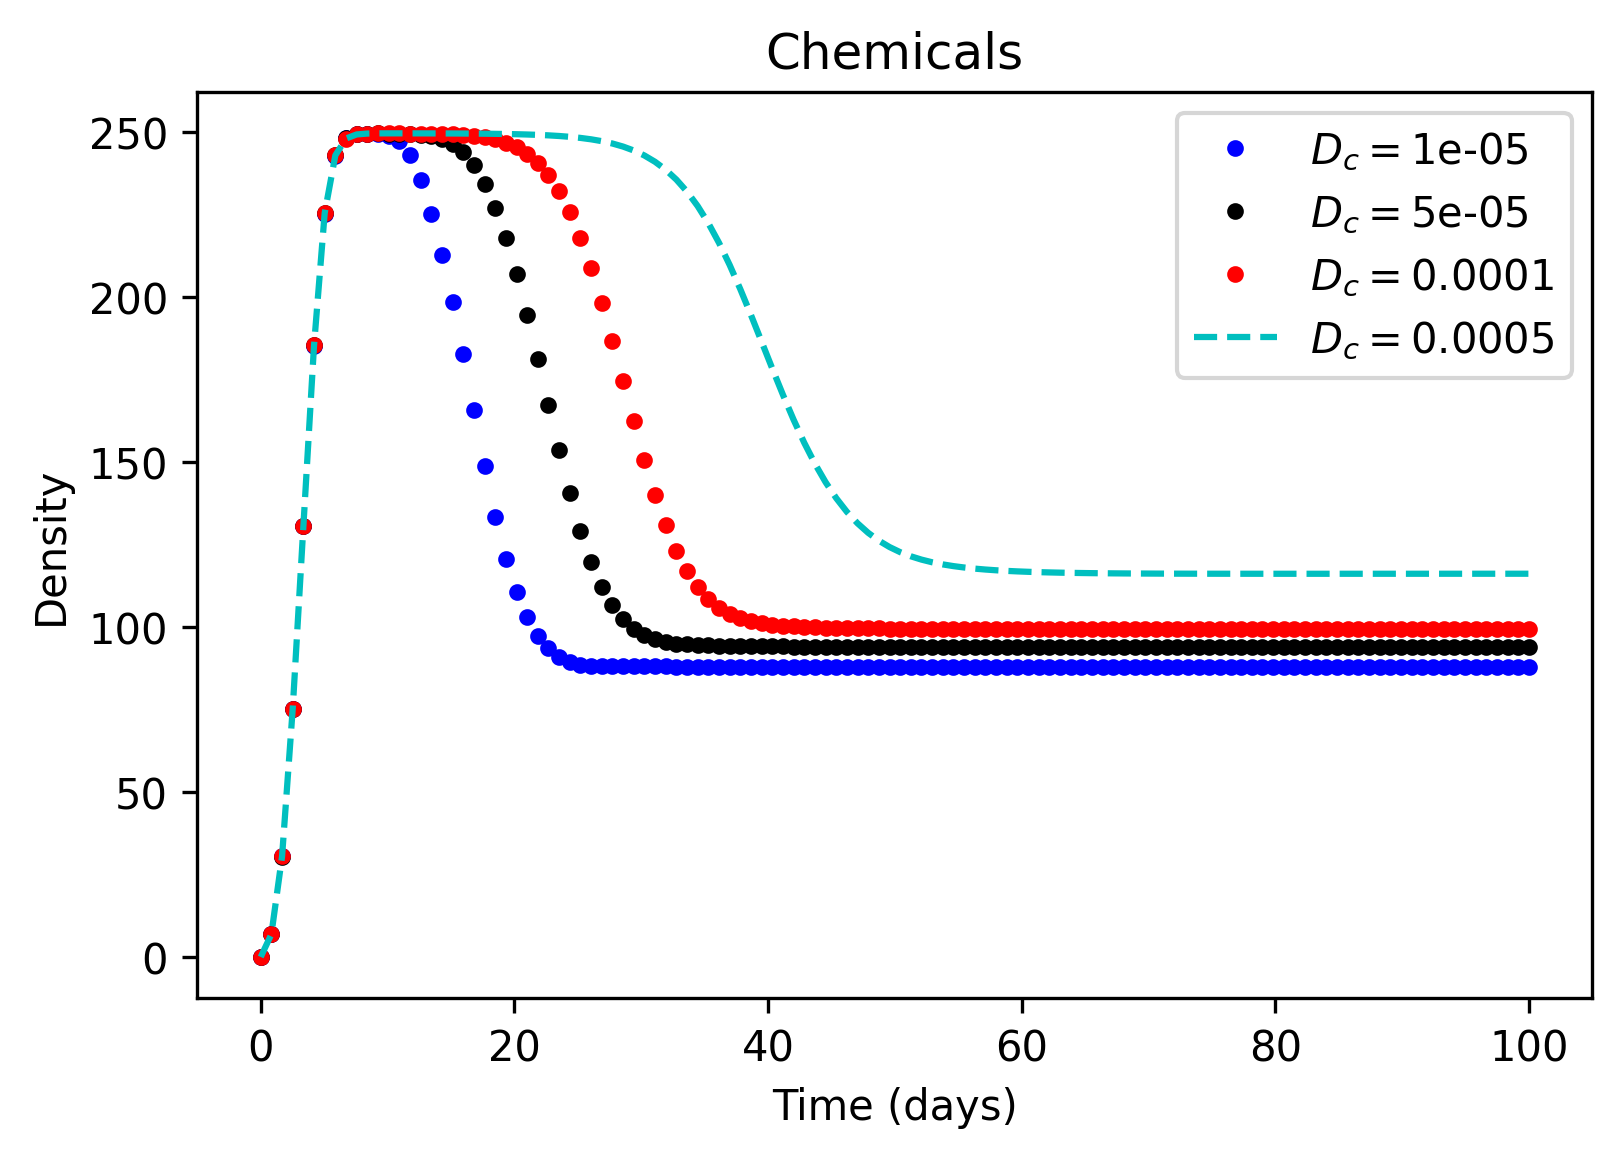

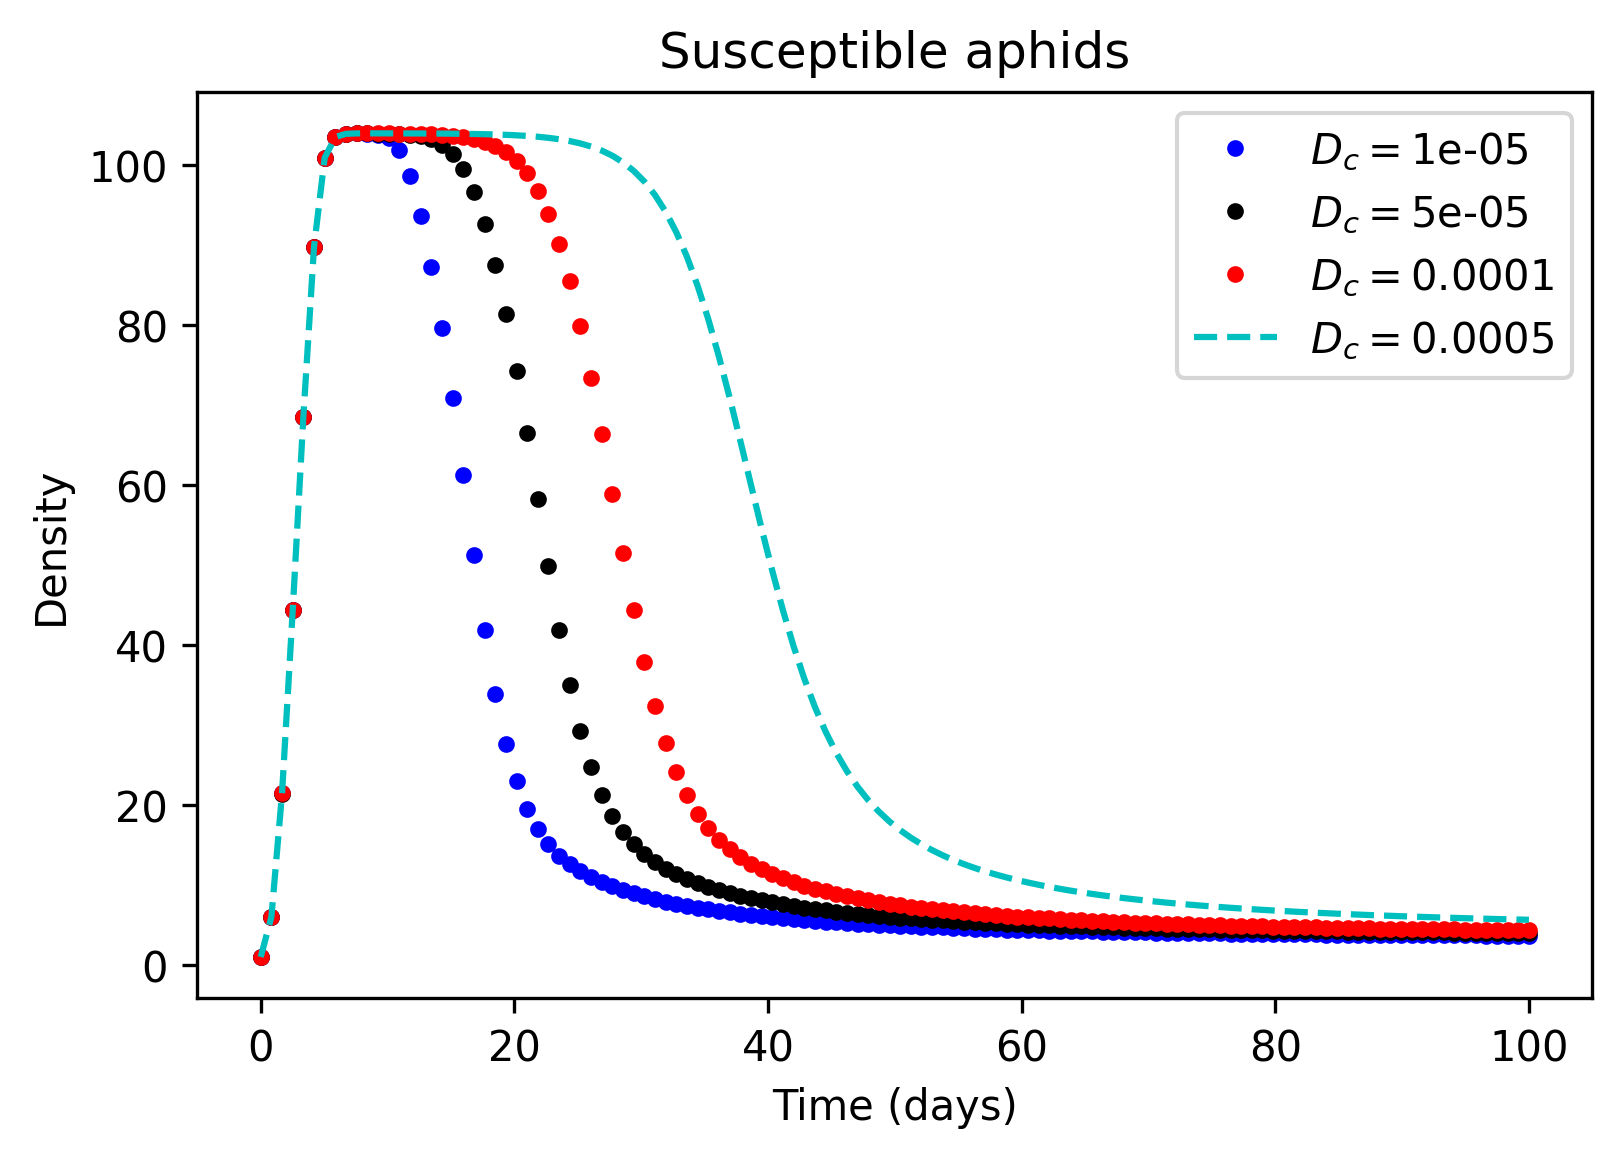

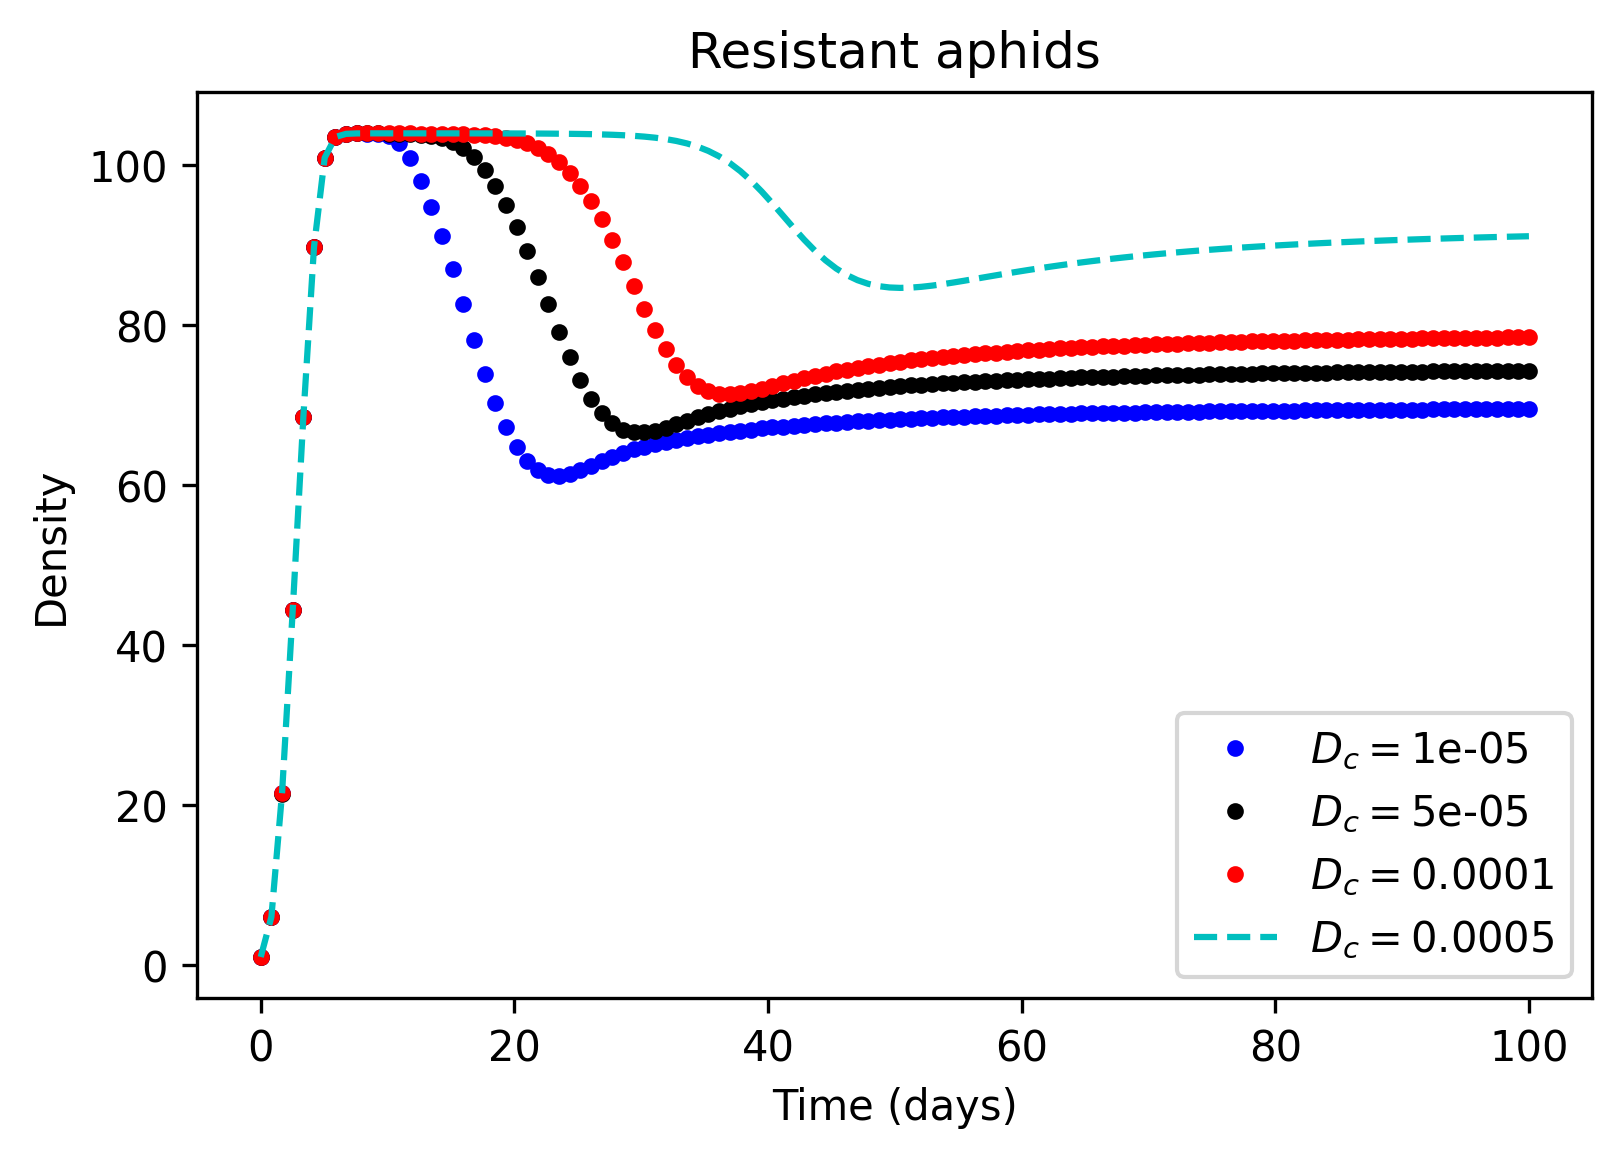

In [64]:
colors = ['b.', 'k.', 'r.', 'c--', 'm-.', 'y-.', 'k-.']
time = np.linspace(0, 100, 120)
for i in range(len(dc)):
    plt.plot(time, P2[:,i], colors[i],  label="$D_c = $" + str(dc[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Parasitoids")
plt.legend()
plt.show()

for i in range(len(dc)):
    plt.plot(time, C2[:,i], colors[i],  label="$D_c = $" + str(dc[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Chemicals")
plt.legend()
plt.show()

for i in range(len(dc)):
    plt.plot(time, H_s2[:,i], colors[i],  label="$D_c = $" + str(dc[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Susceptible aphids")
plt.legend()
plt.show()

for i in range(len(dc)):
    plt.plot(time, H_d2[:,i], colors[i],  label="$D_c = $" + str(dc[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Resistant aphids")
plt.legend()
plt.show()

### Effect of varying $b_3$

In [ ]:
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, ImplicitSolver, Controller, MemoryStorage
import numpy as np

# ram parameters 
D_p = 0.0005 #m^2s^{-1}
D_c = 0.0005 
al = 1
r = 2.55
del_h = 0.15
del_p = 0.15
e_s = 0.3
e_d = 0.2
Sds = 0.65
Ssd = 1
b_1 = 1
b_2 = 1
b_3 = 0.2
chi = 0.01
mu = 1

# varying mu
b3 = [.01, .015, .02, .03, .05, .1, .2, .4, .6, .8, 1]

P3 = np.ndarray((120, len(b3)))
C3 = np.ndarray((120, len(b3)))
H_s3 = np.ndarray((120, len(b3)))
H_d3 = np.ndarray((120, len(b3)))


for i in range(len(b3)):
    b_3 = b3[i]

    parms = [D_p, D_c, al, r, del_h, del_p, e_s, e_d, Sds, Ssd, b_1, b_2, b_3, chi, mu]
    
    P3[:,i], C3[:,i], H_s3[:, i], H_d3[:,i]  = solve_pde(params=parms)
    

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

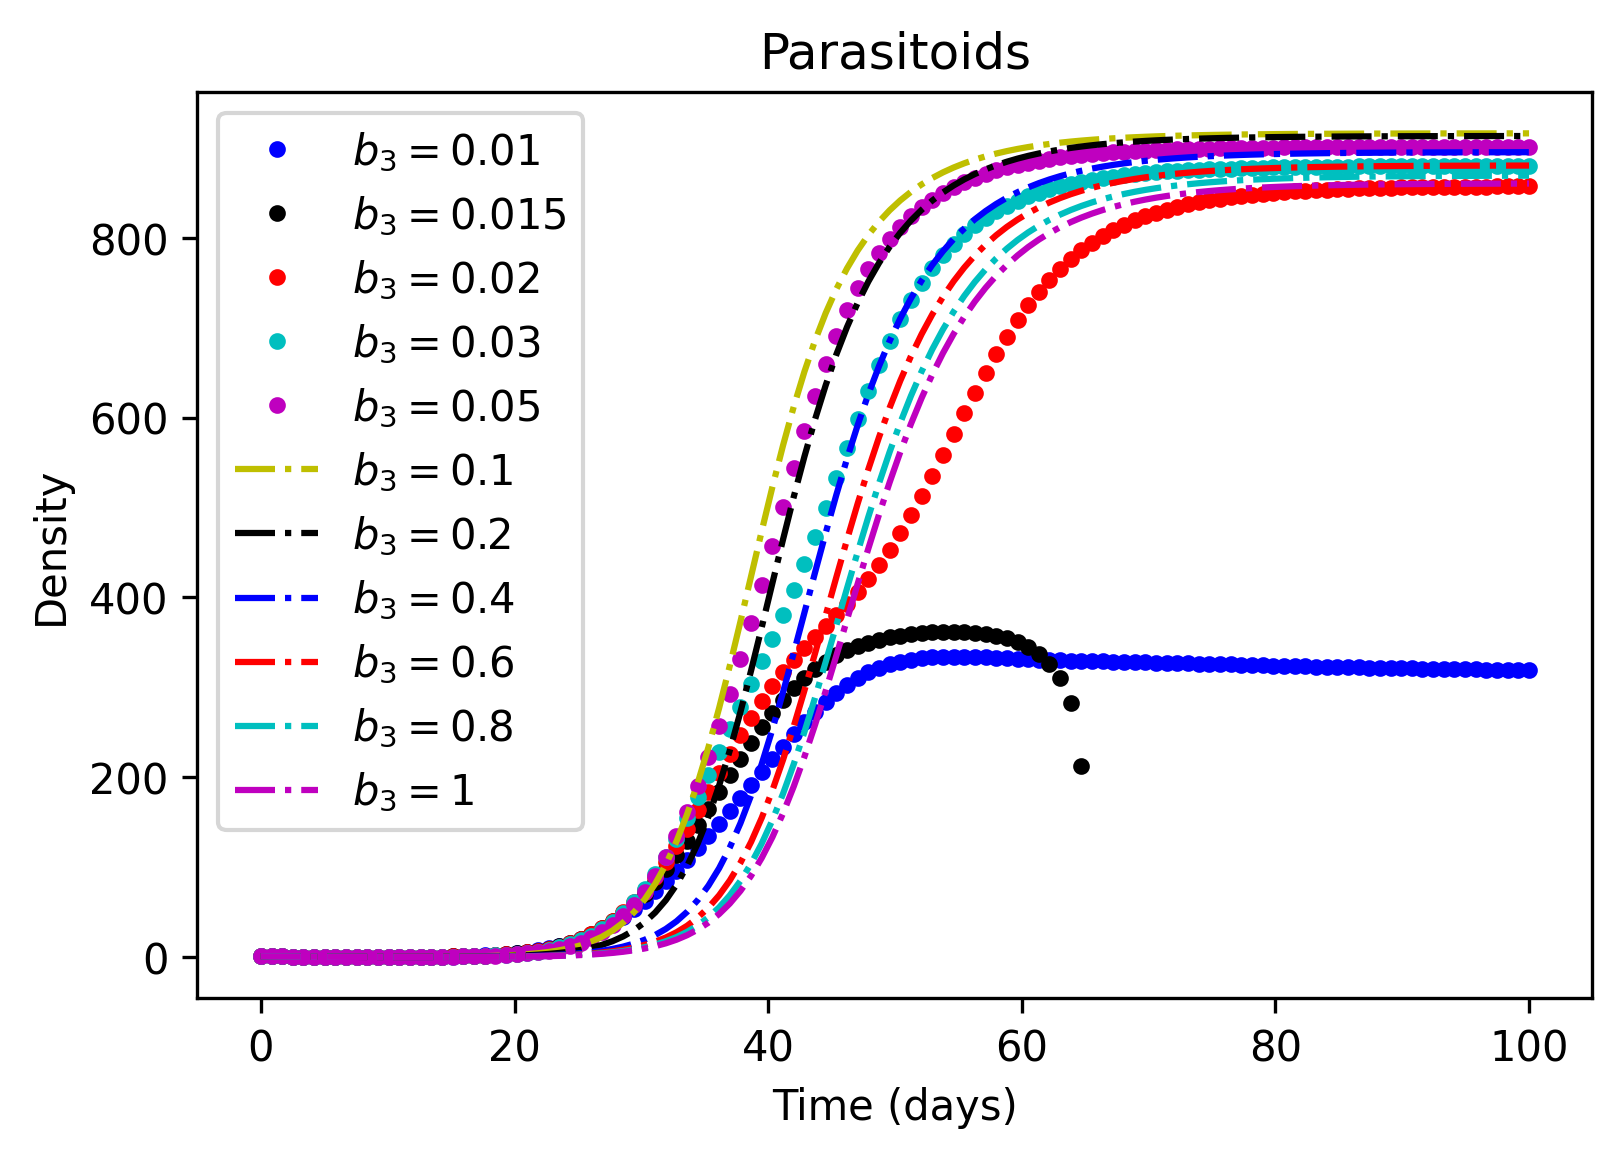

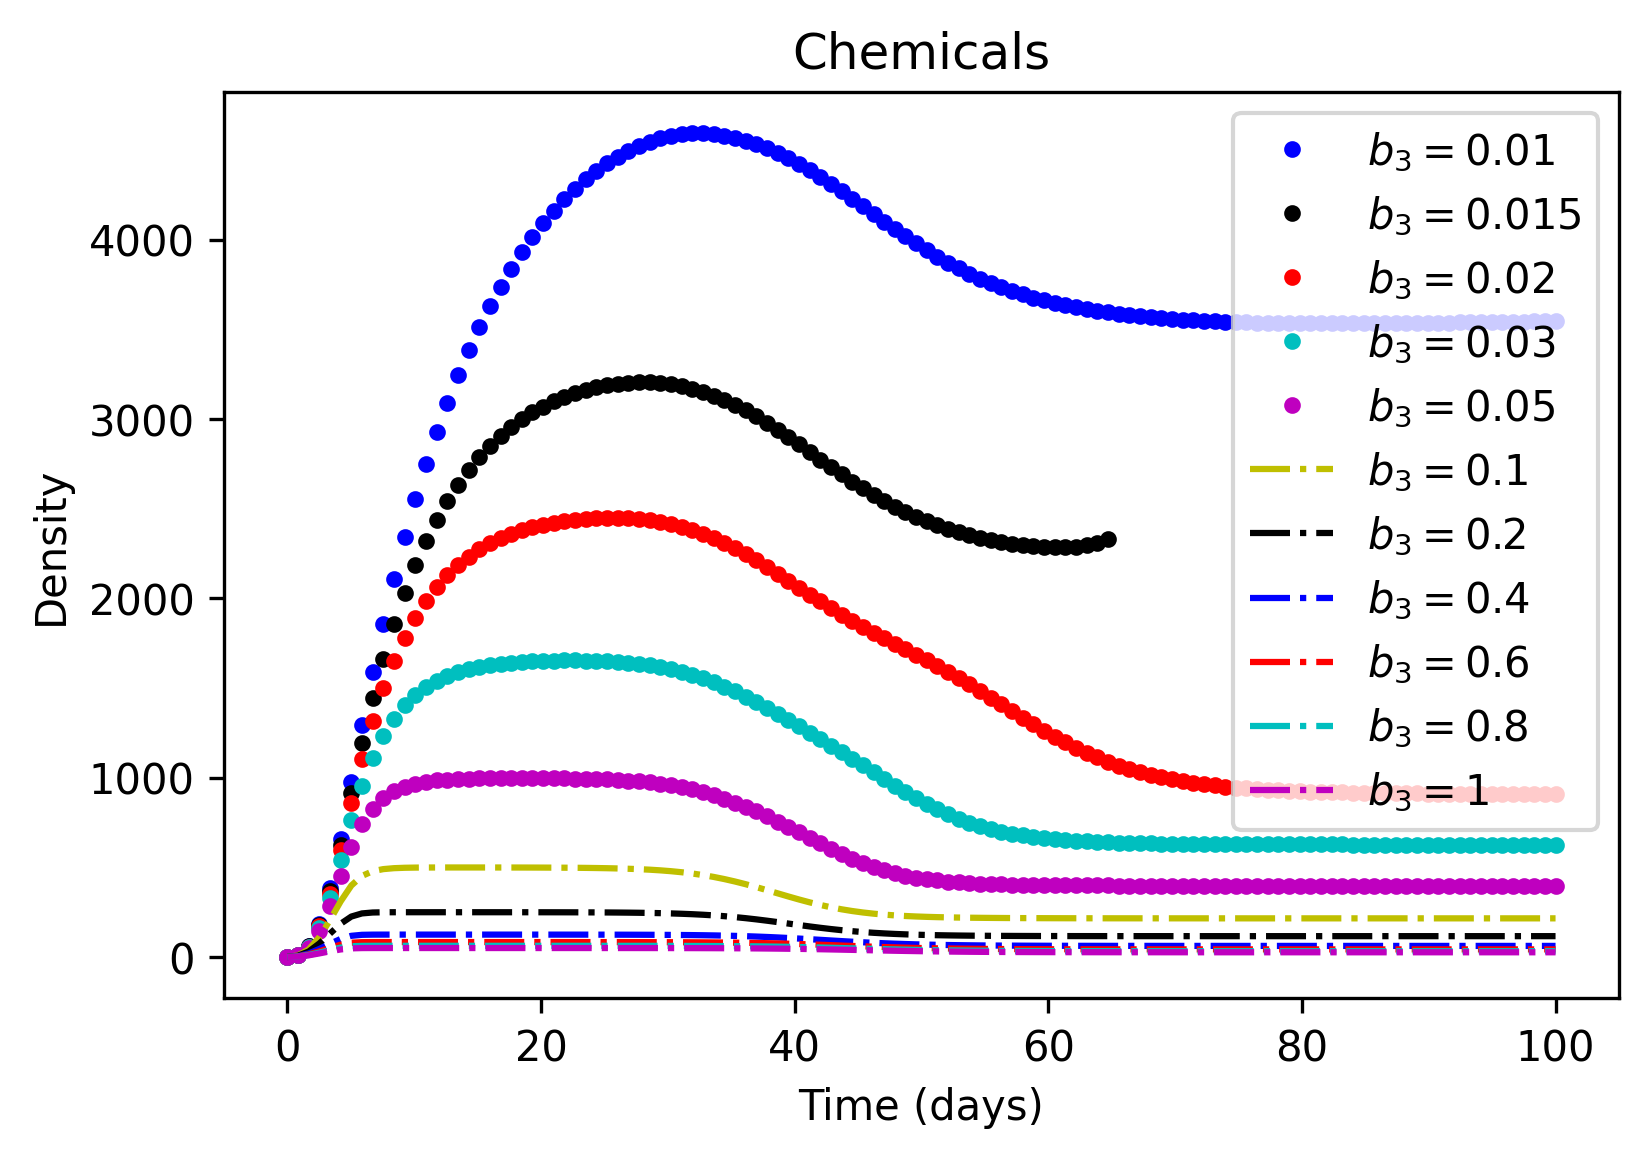

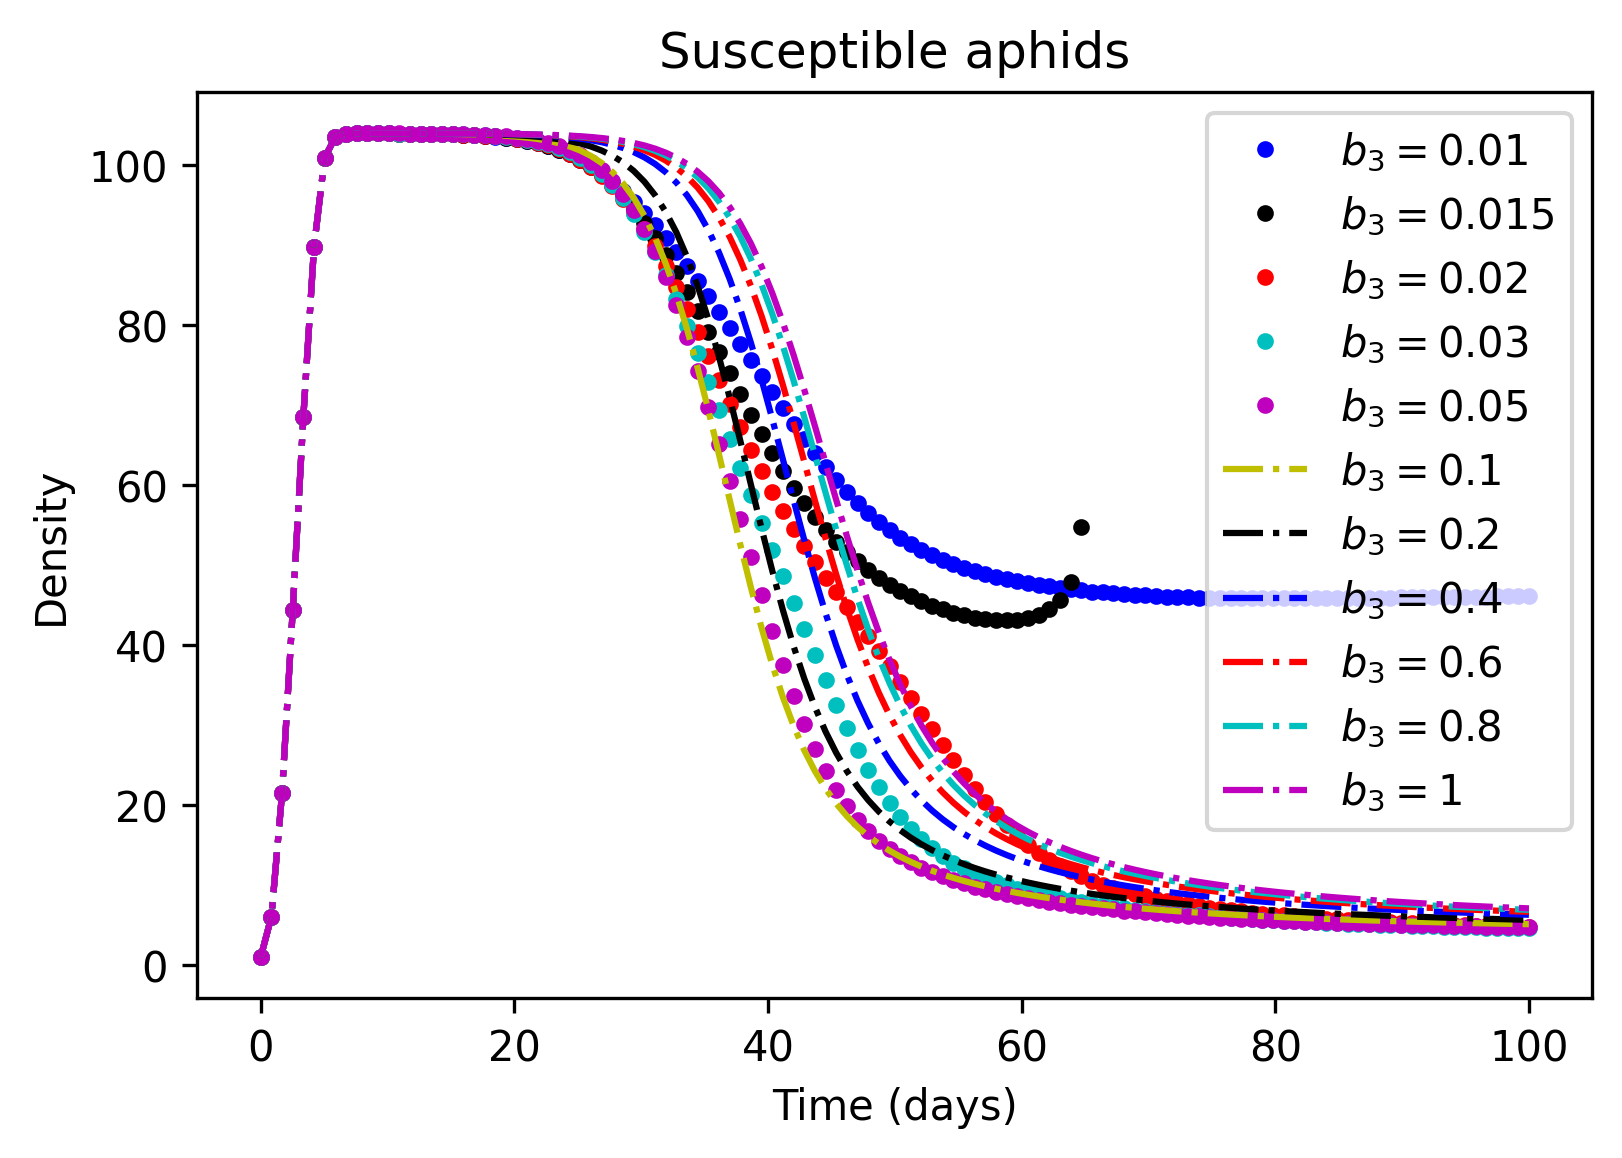

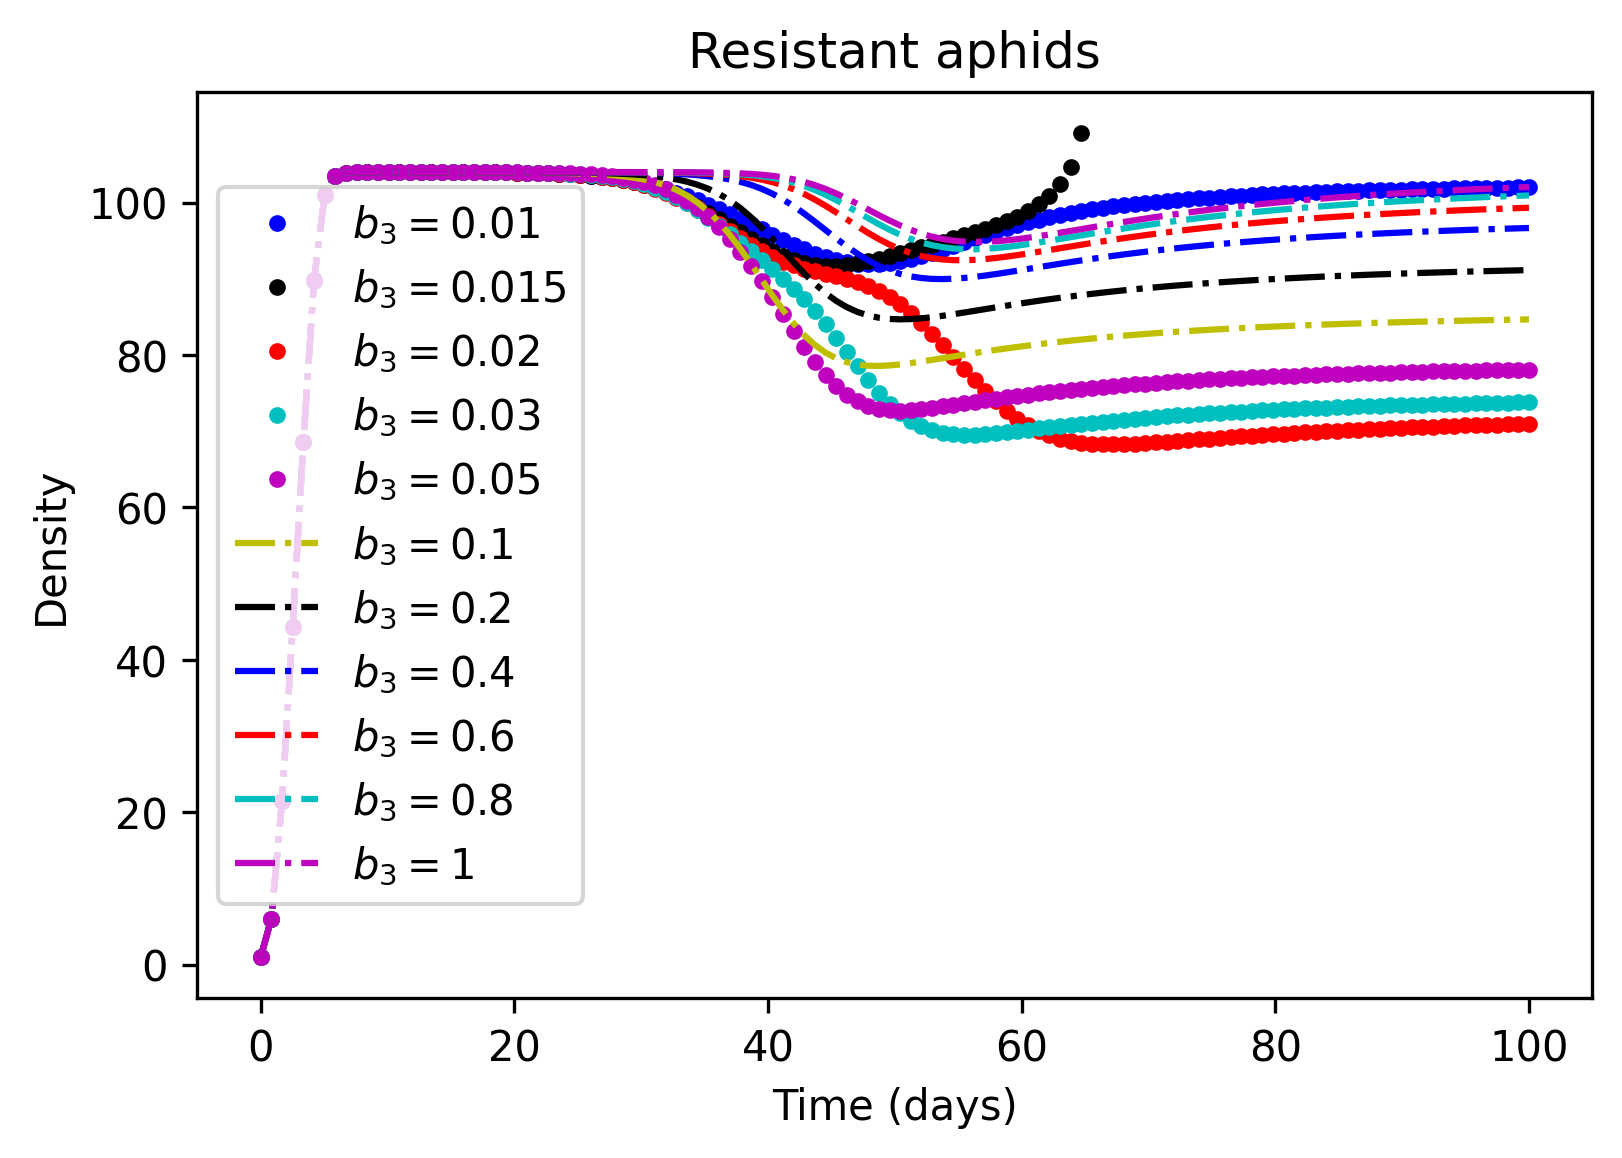

In [93]:
colors = ['b.', 'k.', 'r.', 'c.', 'm.', 'y-.', 'k-.', 'b-.', 'r-.', 'c-.', 'm-.']
time = np.linspace(0, 100, 120)
for i in range(len(b3)):
    plt.plot(time, P3[:,i], colors[i],  label="$b_3 = $" + str(b3[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Parasitoids")
plt.legend()
plt.show()

for i in range(len(b3)):
    plt.plot(time, C3[:,i], colors[i],  label="$b_3 = $" + str(b3[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Chemicals")
plt.legend()
plt.show()

for i in range(len(b3)):
    plt.plot(time, H_s3[:,i], colors[i],  label="$b_3 = $" + str(b3[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Susceptible aphids")
plt.legend()
plt.show()

for i in range(len(b3)):
    plt.plot(time, H_d3[:,i], colors[i],  label="$b_3 = $" + str(b3[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Resistant aphids")
plt.legend()
plt.show()

In [24]:
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, ImplicitSolver, Controller, MemoryStorage
import numpy as np

# ram parameters 
D_p = 0.0005 #m^2s^{-1}
D_c = 0.0005 
al = 1
r = 2.55
del_h = 0.15
del_p = 0.15
e_s = 0.3
e_d = 0.2
Sds = 0.65
Ssd = 1
b_1 = 1
b_2 = 1
b_3 = 0.2
chi = 0.01
mu = 1

# varying mu
alpha = [1, 2, 3, 4, 5, 6, 7, 8, 9]

P_a = np.ndarray((120, len(alpha)))
C_a = np.ndarray((120, len(alpha)))
H_s_a = np.ndarray((120, len(alpha)))
H_d_a = np.ndarray((120, len(alpha)))


for i in range(len(alpha)):
    al = alpha[i]

    parms = [D_p, D_c, al, r, del_h, del_p, e_s, e_d, Sds, Ssd, b_1, b_2, b_3, chi, mu]
    
    P_a[:,i], C_a[:,i], H_s_a[:, i], H_d_a[:,i]  = solve_pde(params=parms)
    

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

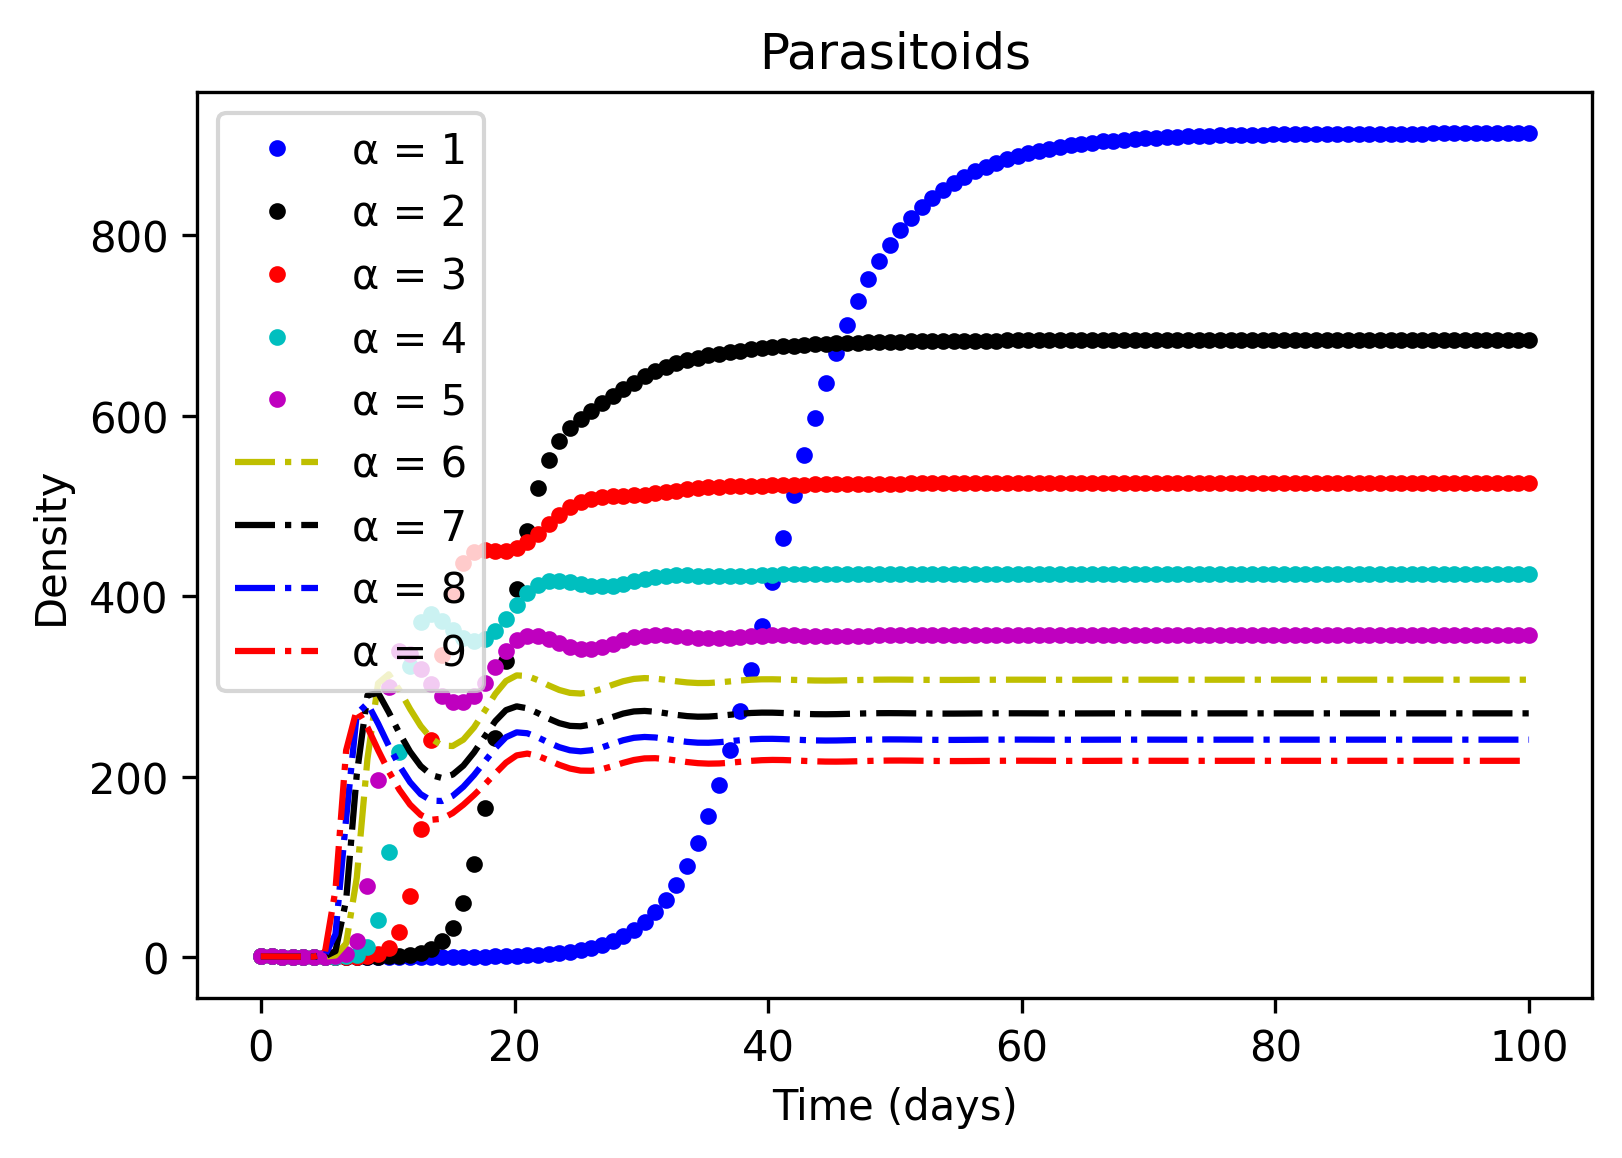

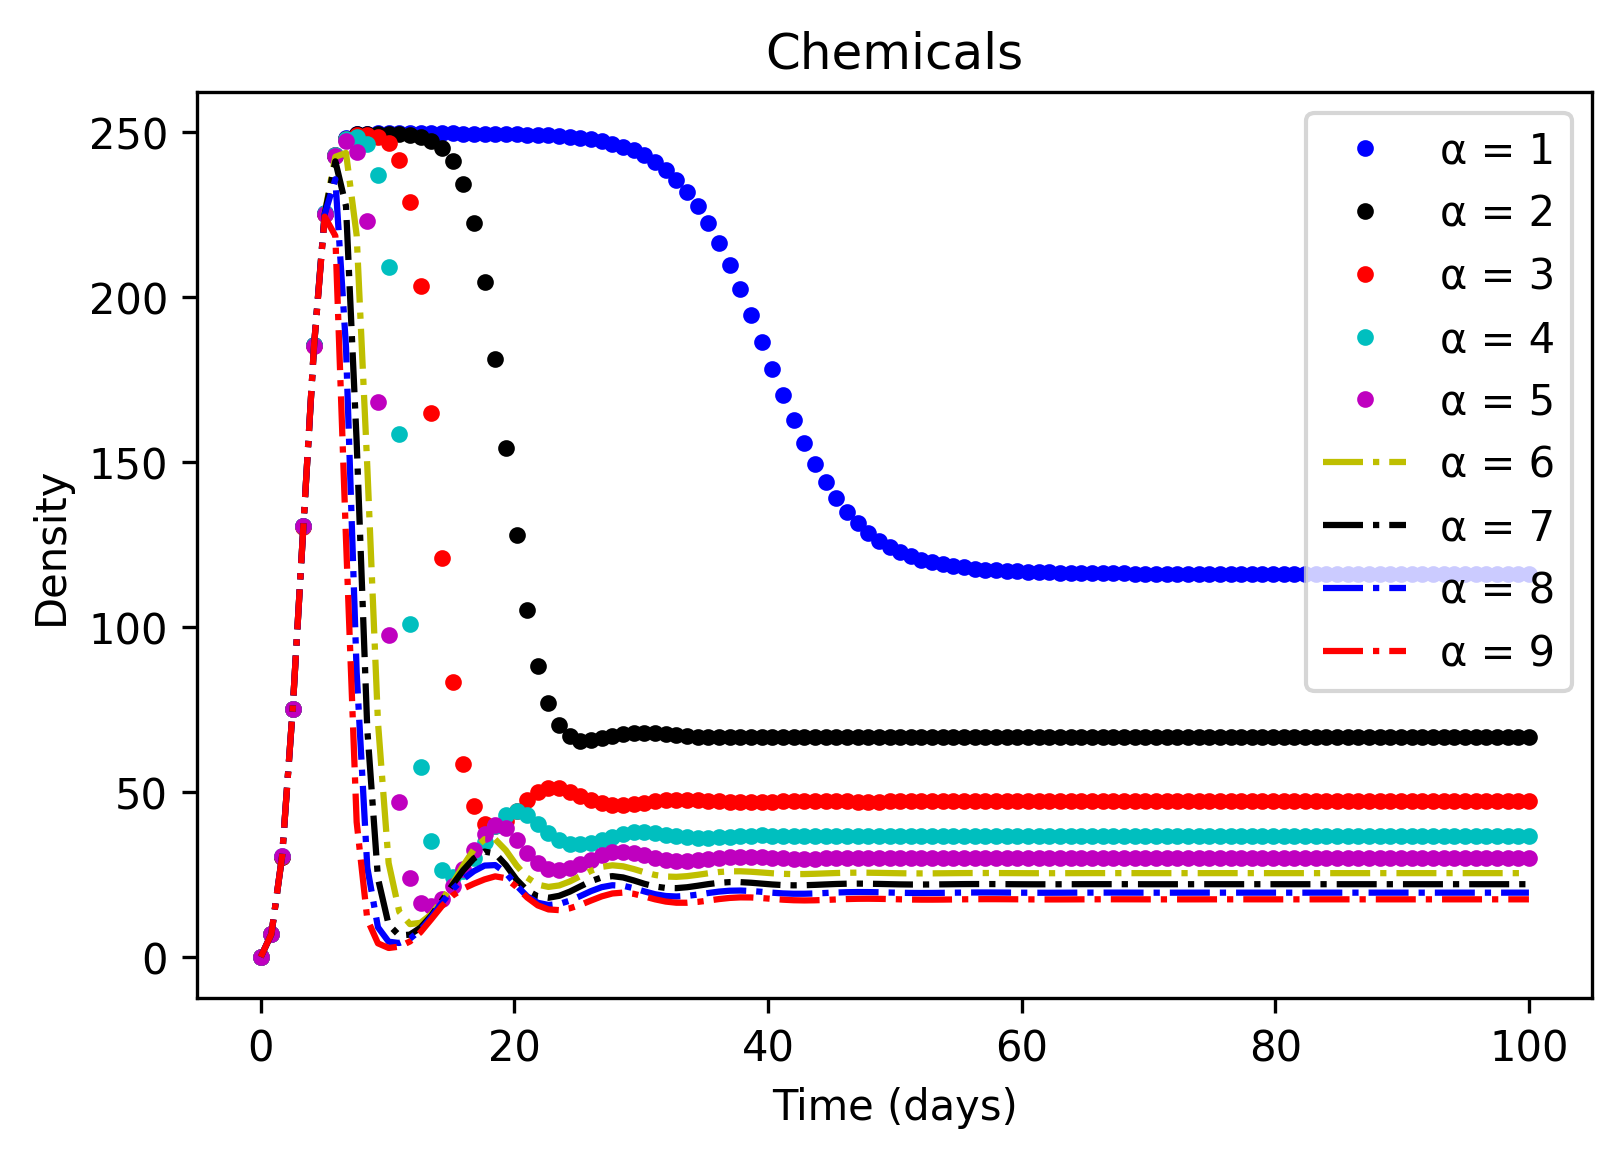

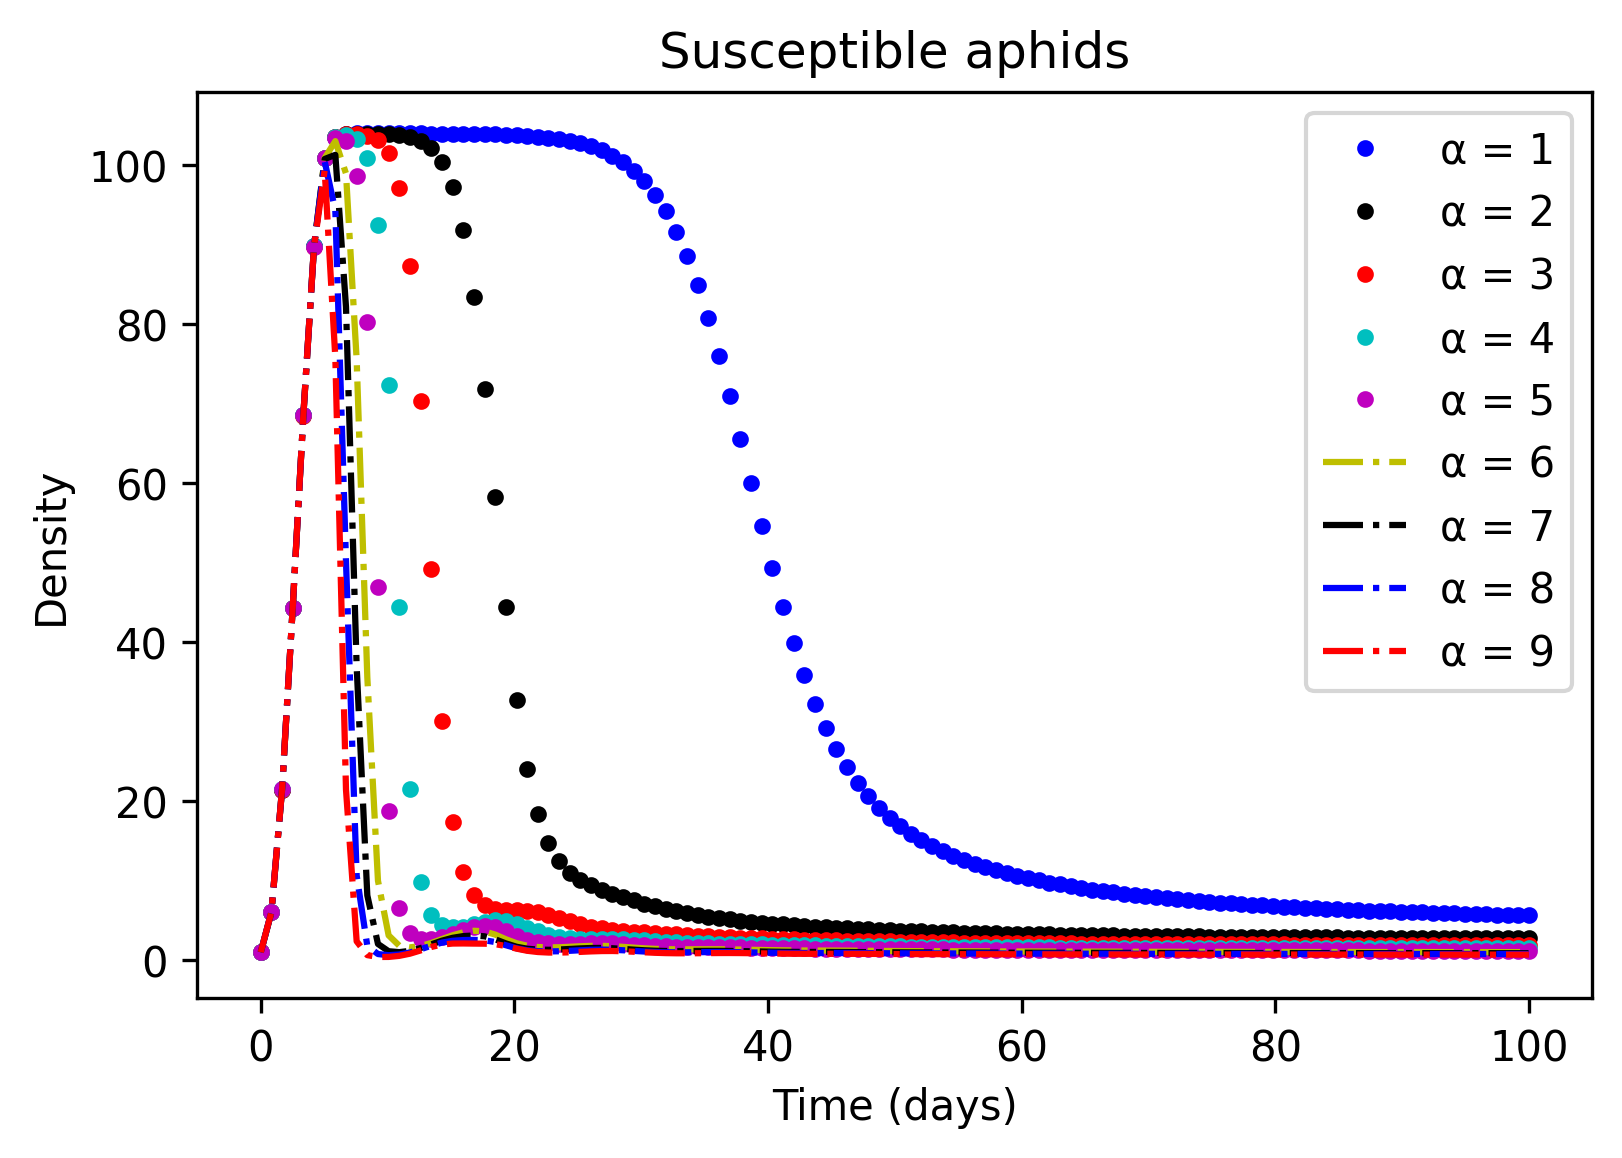

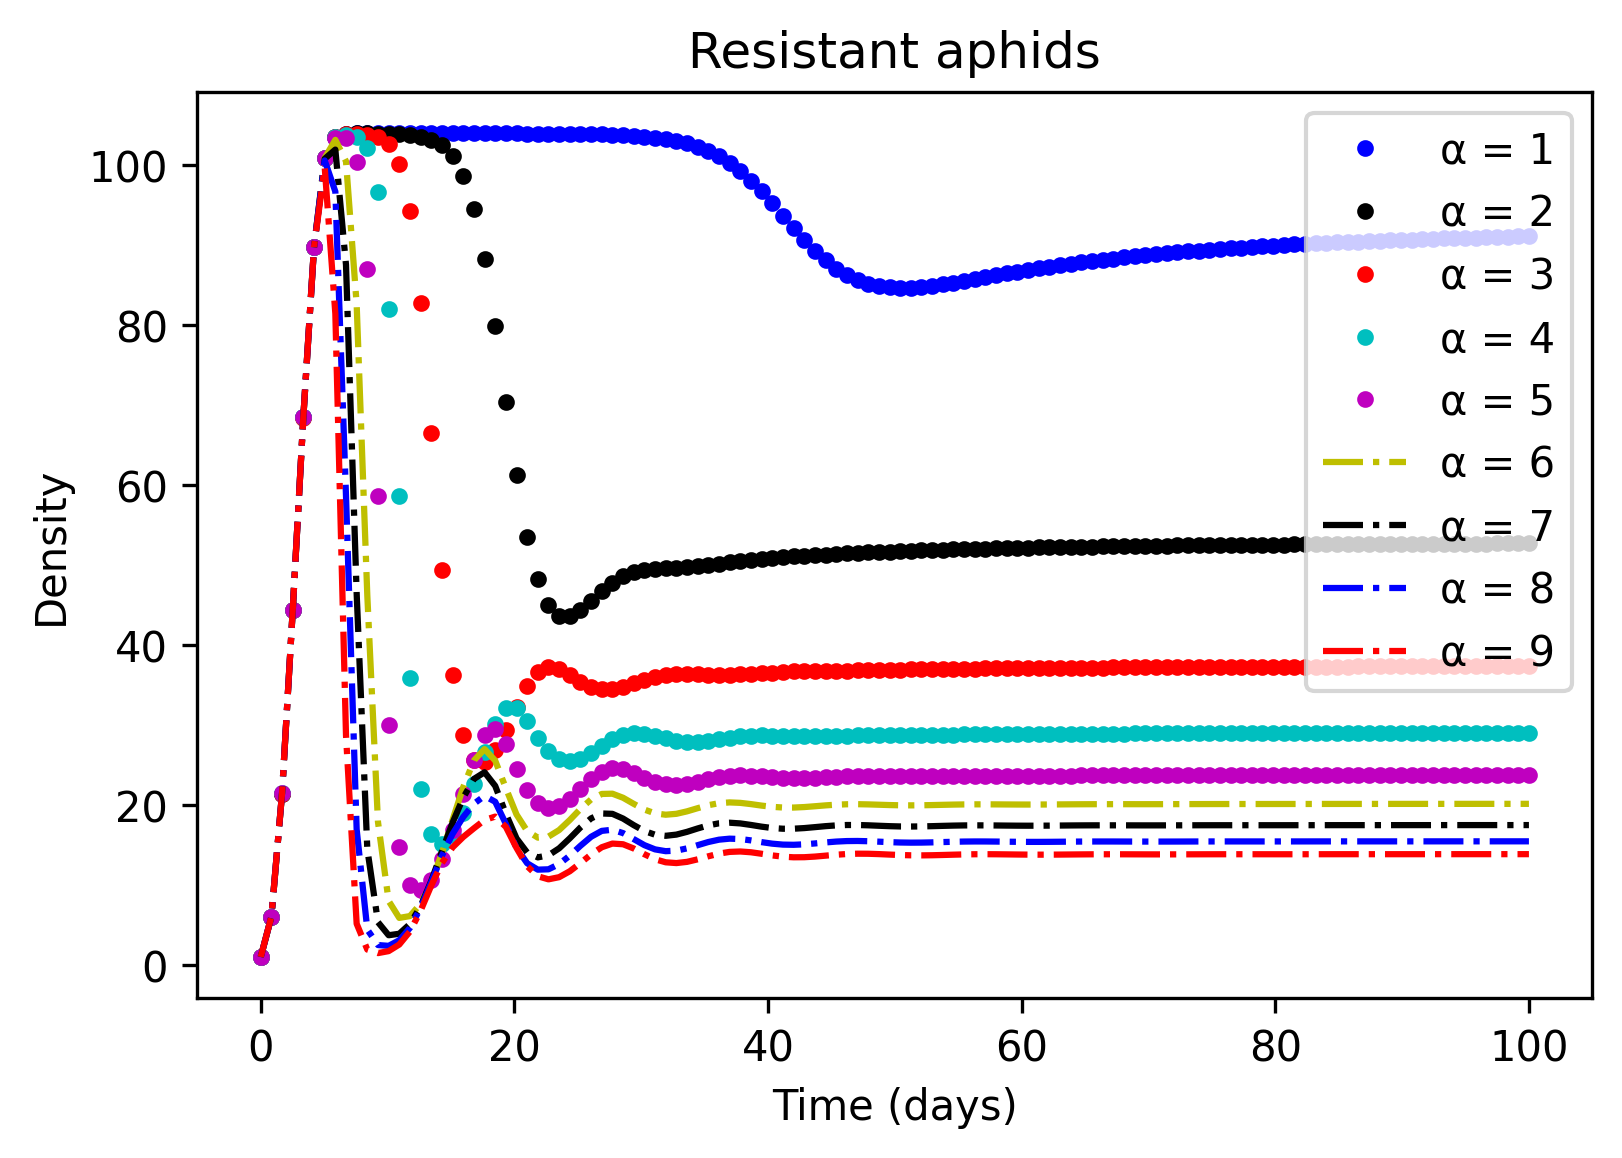

In [25]:
colors = ['b.', 'k.', 'r.', 'c.', 'm.', 'y-.', 'k-.', 'b-.', 'r-.', 'c-.', 'm-.']
time = np.linspace(0, 100, 120)
for i in range(len(alpha)):
    plt.plot(time, P_a[:,i], colors[i],  label="α = " + str(alpha[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Parasitoids")
plt.legend()
plt.show()

for i in range(len(alpha)):
    plt.plot(time, C_a[:,i], colors[i],  label="α = " + str(alpha[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Chemicals")
plt.legend()
plt.show()

for i in range(len(alpha)):
    plt.plot(time, H_s_a[:,i], colors[i],  label="α = " + str(alpha[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Susceptible aphids")
plt.legend()
plt.show()

for i in range(len(alpha)):
    plt.plot(time, H_d_a[:,i], colors[i],  label="α = " + str(alpha[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Resistant aphids")
plt.legend()
plt.show()

In [34]:
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, ImplicitSolver, Controller, MemoryStorage
import numpy as np

# ram parameters 
D_p = 0.0005 #m^2s^{-1}
D_c = 0.0005 
al = 1
r = 2.55
del_h = 0.15
del_p = 0.15
e_s = 0.3
e_d = 0.2
Sds = 0.65
Ssd = 1
b_1 = 1
b_2 = 1
b_3 = 0.2
chi = 0.01
mu = 1

# varying mu
epsilon = [.2, .3, .4, .5, .6]

P_e = np.ndarray((120, len(epsilon)))
C_e = np.ndarray((120, len(epsilon)))
H_s_e = np.ndarray((120, len(epsilon)))
H_d_e = np.ndarray((120, len(epsilon)))


for i in range(len(epsilon)):
    e_s = epsilon[i]

    parms = [D_p, D_c, al, r, del_h, del_p, e_s, e_d, Sds, Ssd, b_1, b_2, b_3, chi, mu]
    
    P_e[:,i], C_e[:,i], H_s_e[:, i], H_d_e[:,i]  = solve_pde(params=parms)
    

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

  0%|          | 0/240.0 [00:00<?, ?it/s]

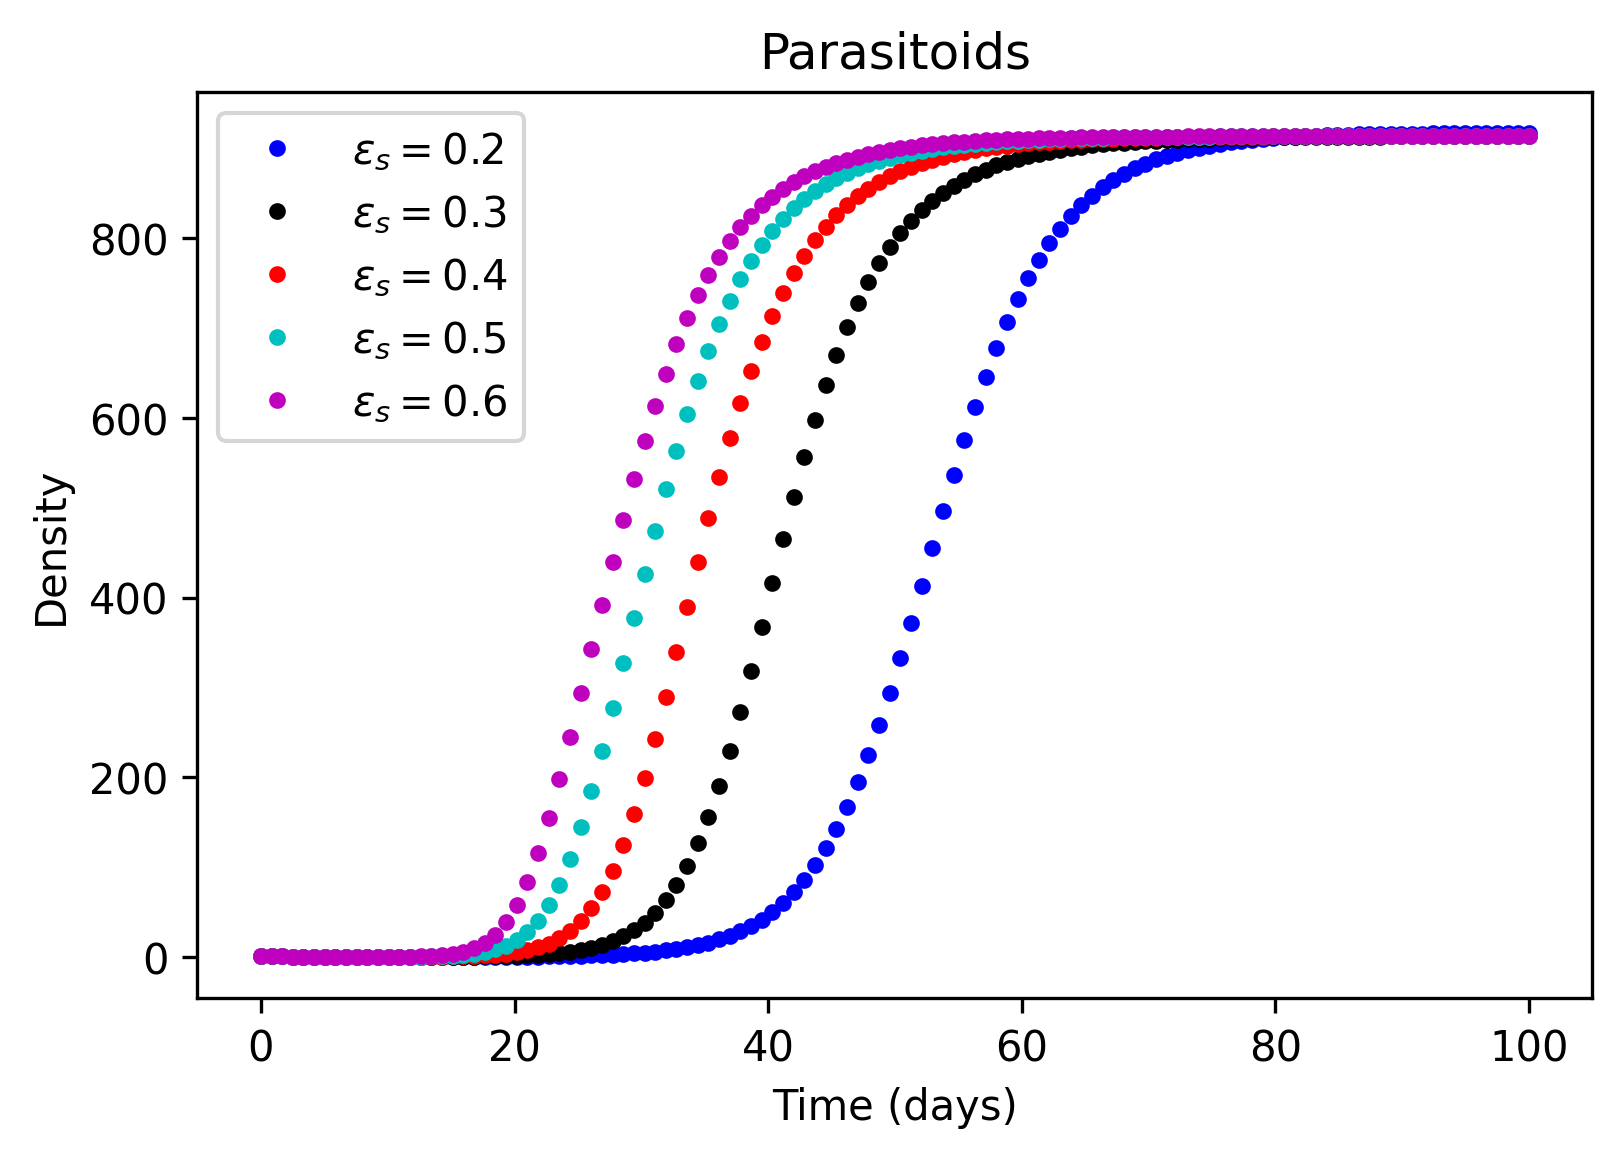

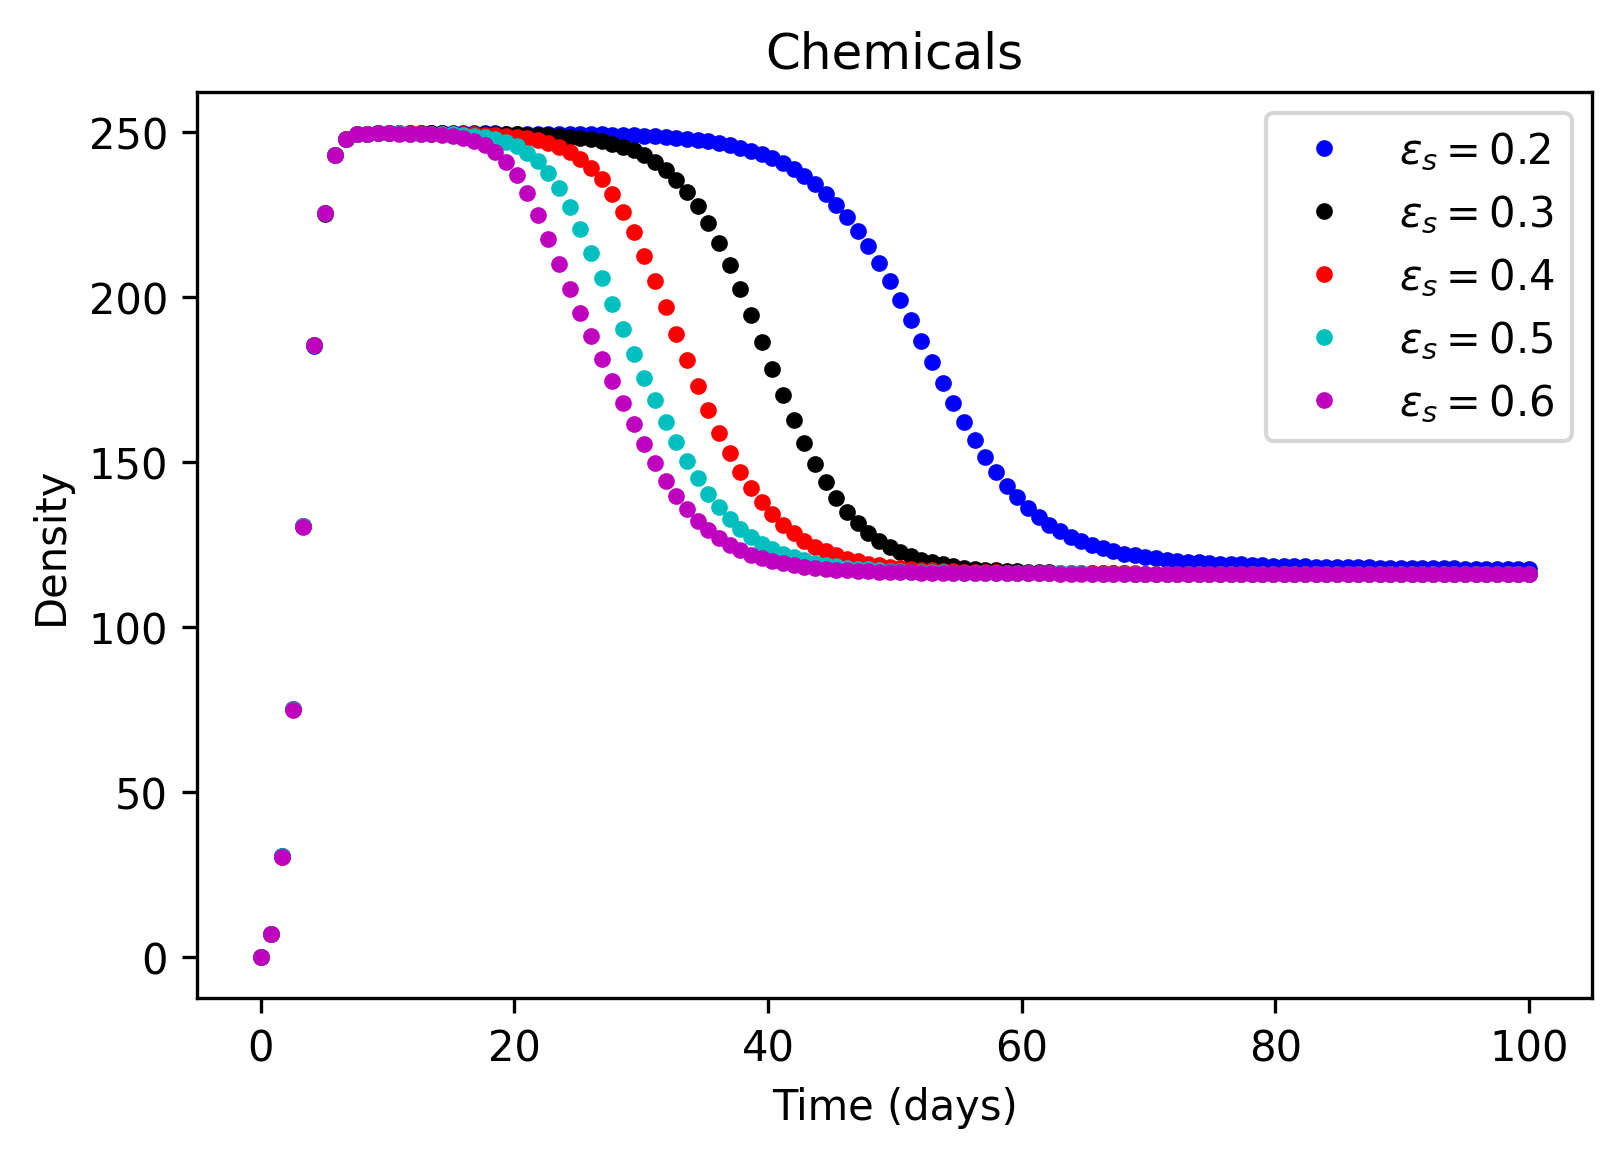

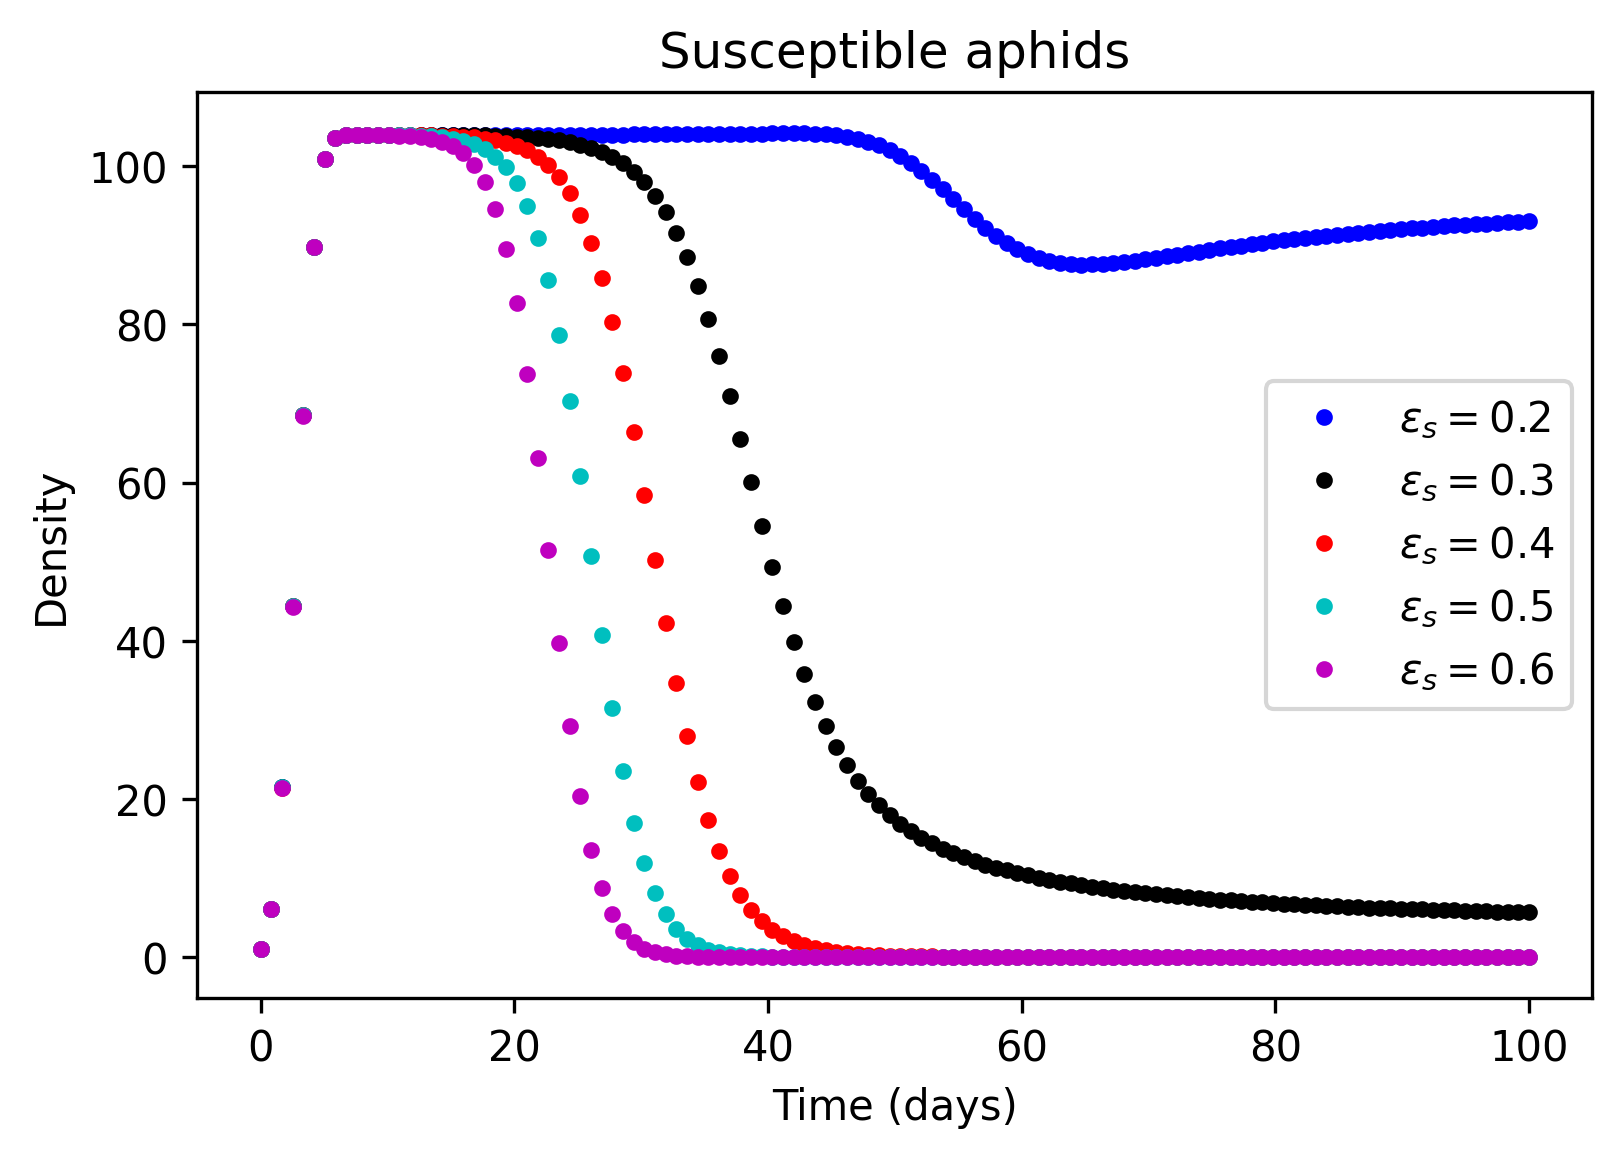

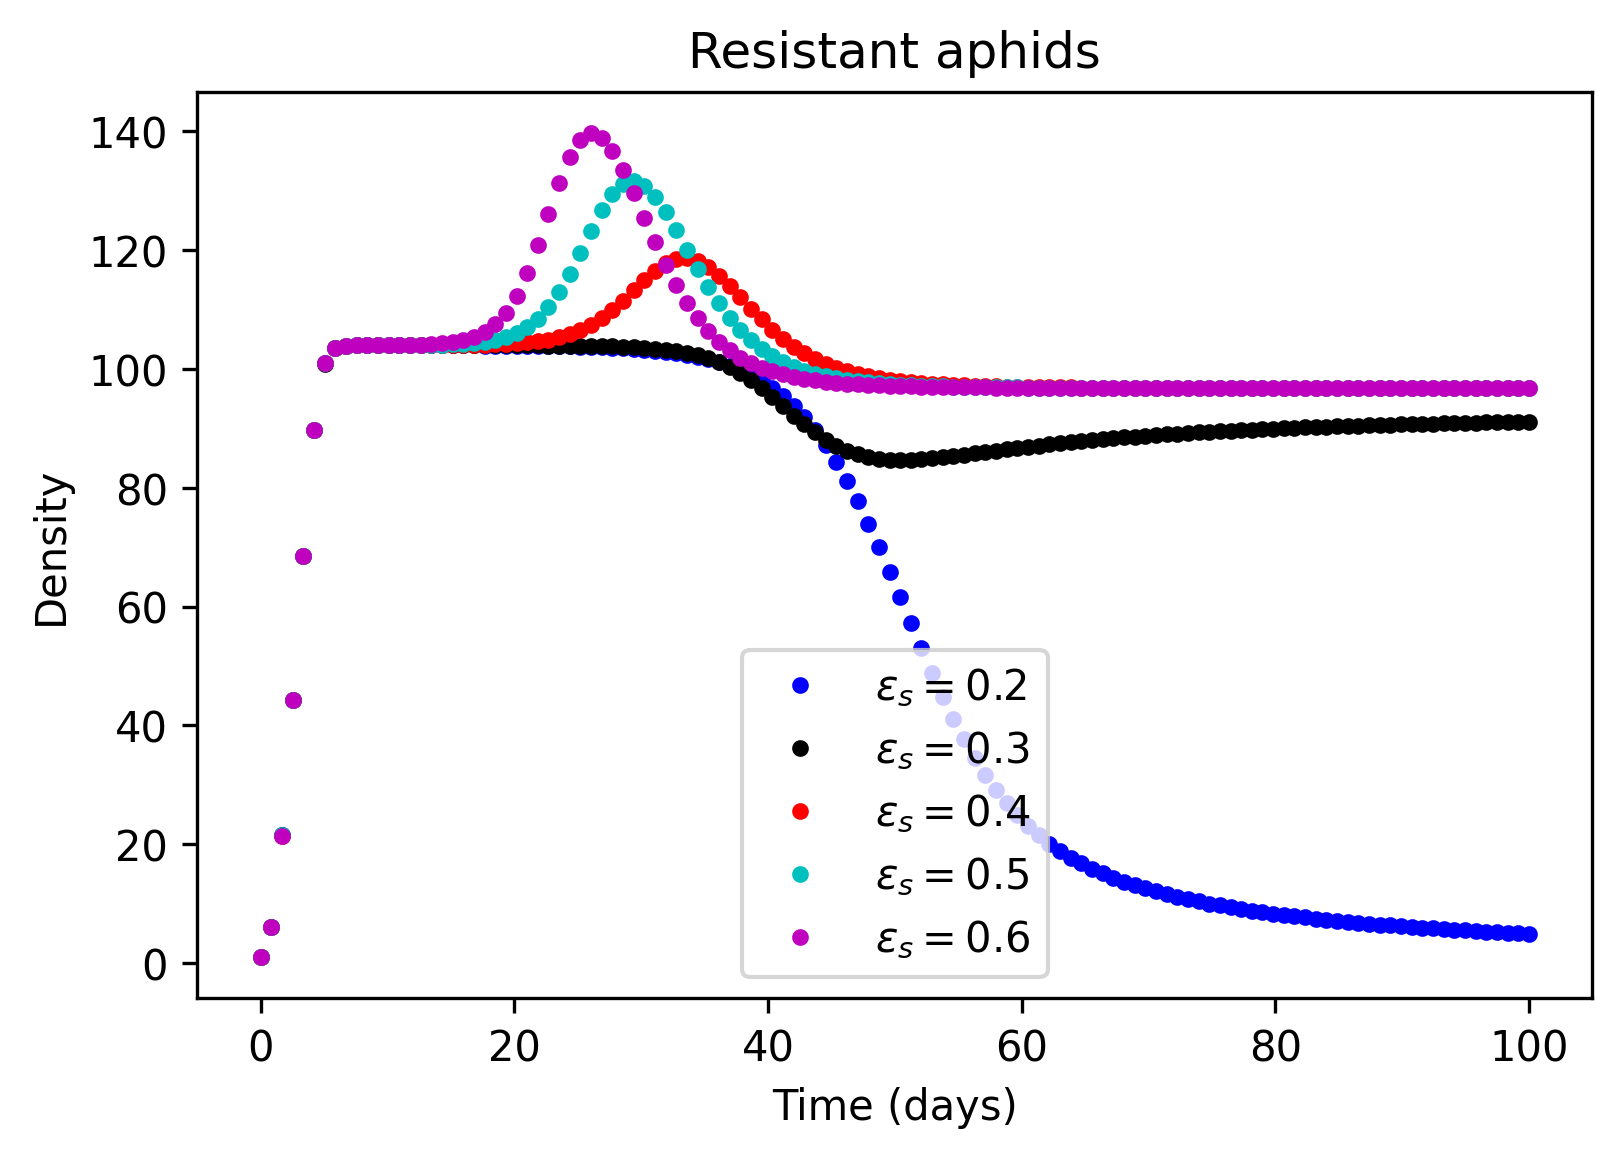

In [37]:
colors = ['b.', 'k.', 'r.', 'c.', 'm.', 'y-.', 'k-.', 'b-.', 'r-.', 'c-.', 'm-.']
time = np.linspace(0, 100, 120)
for i in range(len(epsilon)):
    plt.plot(time, P_e[:,i], colors[i],  label="$\epsilon_s = $" + str(epsilon[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Parasitoids")
plt.legend()
plt.show()

for i in range(len(epsilon)):
    plt.plot(time, C_e[:,i], colors[i],  label="$\epsilon_s = $" + str(epsilon[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Chemicals")
plt.legend()
plt.show()

for i in range(len(epsilon)):
    plt.plot(time, H_s_e[:,i], colors[i],  label="$\epsilon_s = $" + str(epsilon[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Susceptible aphids")
plt.legend()
plt.show()

for i in range(len(epsilon)):
    plt.plot(time, H_d_e[:,i], colors[i],  label="$\epsilon_s = $" + str(epsilon[i]))

plt.xlabel("Time (days)")
plt.ylabel("Density")
plt.title("Resistant aphids")
plt.legend()
plt.show()

## Running with a different initial condition

In [26]:
def double_hill(N, width):     
    X = gkern(int(N/10), width)
    A = np.zeros((N, N))
    A[5 :int(N/10)+5, 5: int(N/10)+5] = X
    A[N-int(N/10)-5:N-5, N-int(N/10)-5:N-5] = X
    return A/(np.sum(A))

A_3 = np.random.rand(N, N)
A_3 = A_3/np.sum(A_3)



A_2 = double_hill(N, 2)
